In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import sys
import numpy as np
from torch.utils.data import DataLoader

import torch.optim as optim
import torch
import torch.nn as nn
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from HRIRDataset import HRIRDataset
# from BasicTransformer import BasicTransformer

sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
# Basic Dataset only loads the HRIRs at 0 degrees and 90 degrees for baseline and 45 degree for testing
hrir_dataset = HRIRDataset()
for i in range(1,100):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))
train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.2 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)


device = torch.device('cuda')

loss_function = nn.MSELoss()

num_epochs = 200 # Number of epochs to train for

# total_epochs = 100
warmup_epochs = 10
base_lr = 1e-3

# Define lambda function for the learning rate schedule
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        # Linear warm-up
        return float(epoch) / float(max(1, warmup_epochs))
    else:
        # Exponential decay
        decay_rate = 0.95  # Decay rate
        decay_epochs = epoch - warmup_epochs  # Subtract warmup epochs
        return pow(decay_rate, decay_epochs)




In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, encoding_dim),
#             nn.Tanh()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, input_dim),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

import torch
import torch.nn as nn

class Unflatten(nn.Module):
    def __init__(self, num_channels, seq_length):
        super(Unflatten, self).__init__()
        self.num_channels = num_channels
        self.seq_length = seq_length

    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, self.num_channels, self.seq_length)

class Conv1DAutoencoder(nn.Module):
    def __init__(self, channels, encoding_dim):
        super(Conv1DAutoencoder, self).__init__()
        # Assuming the input size is [batch_size, channels, seq_length] = [32, 2, 512]
        self.encoder = nn.Sequential(
            nn.Conv1d(channels, 16, kernel_size=3, stride=2, padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.Flatten(),
            nn.Linear(32 * 128, encoding_dim),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 128),
            nn.LeakyReLU(True),
            Unflatten(32, 128),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.ConvTranspose1d(16, channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjusted for correct output size
            nn.Tanh()
        )

    def forward(self, x):
        # x = self.encoder(x)
        # x = self.decoder(x)
        print(f"Input shape: {x.shape}")
        # return x
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            print(f"After encoder layer {i+1} ({layer.__class__.__name__}): {x.shape}")
        
        # for i, layer in enumerate(self.decoder):
        #     x = layer(x)
        #     print(f"After decoder layer {i+1} ({layer.__class__.__name__}): {x.shape}")
        
        return x



class HRIRTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, encoding_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, n_angle_bins, angle_embedding_dim):
        super(HRIRTransformer, self).__init__()
        self.autoencoder = Conv1DAutoencoder(2, encoding_dim)
        self.positional_encoder = PositionalEncoding(d_model=encoding_dim + angle_embedding_dim)  # Adjust for angle embedding

        self.angle_embedding = nn.Embedding(n_angle_bins, angle_embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=encoding_dim + angle_embedding_dim, nhead=nhead, dim_feedforward=dim_feedforward)  # Adjust for angle embedding
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=encoding_dim + angle_embedding_dim, nhead=nhead, dim_feedforward=dim_feedforward)  # Adjust for angle embedding
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.fc_out = nn.Linear(encoding_dim + angle_embedding_dim, output_dim)  # Adjust for angle embedding
    
    def forward(self, src, src_angle_idx, tgt, tgt_angle_idx, diffs):
        '''
        src: (S, N, E) - (sequence length, batch size, input dimension) - (2, 32, 512)
        tgt: (T, N, E) - (sequence length, batch size, input dimension) - (1, 32, 512)
        src_angle_idx: (N, ) - (batch size, ) - (32, )
        tgt_angle_idx: (N, ) - (batch size, ) - (32, )
        diffs: (S, N, E) - (sequence length, batch size, input dimension) - (2, 32, 512)
        diff_angles: (N, ) - (batch size, ) - (32, )
        '''
        # Convert angles to embeddings
        # print(src_angle_idx)
        # print(tgt_angle_idx)
        # print(diff_angles)
        src_angle_embedding = self.angle_embedding(src_angle_idx)
        tgt_angle_embedding = self.angle_embedding(tgt_angle_idx)

        print("Src_angle_embedding: ", src_angle_embedding.shape)
        print("Tgt_angle_embedding: ", tgt_angle_embedding.shape)
        # diffs_angle_embedding = self.angle_embedding(diff_angles)

        # src_angle_embedding: (N, E) - (batch size, angle embedding dimension) - (32, 16)
        # tgt_angle_embedding: (N, E) - (batch size, angle embedding dimension) - (32, 16)
        # diffs_angle_embedding: (N, E) - (batch size, angle embedding dimension) - (32, 16)

        # Encode src and tgt using autoencoder's encoder
        print("Before encoding src: ", src.shape)
        
        # src_encoded = self.autoencoder.encoder(src)
        src_encoded = self.autoencoder(src)
        return src_encoded
        print("Before encoding tgt: ", tgt.shape)
        tgt_encoded = self.autoencoder.encoder(tgt)
        print("Before encoding diffs: ", diffs.shape)
        diffs_encoded = self.autoencoder.encoder(diffs)
        print("Src_encoded: ", src_encoded.shape)
        print("Tgt_encoded: ", tgt_encoded.shape)
        print("Diffs_encoded: ", diffs_encoded.shape)

        # src_encoded: (S, N, E) - (sequence length, batch size, encoding dimension) - (2, 32, 128)
        # tgt_encoded: (T, N, E) - (sequence length, batch size, encoding dimension) - (1, 32, 128)
        # diffs_encoded: (S, N, E) - (sequence length, batch size, encoding dimension) - (2, 32, 128)

        # Convert angle embeddings to (1, 32, 16)
        src_angle_embedding = src_angle_embedding.unsqueeze(0)
        tgt_angle_embedding = tgt_angle_embedding.unsqueeze(0)
        # diffs_angle_embedding = diffs_angle_embedding.unsqueeze(0)

        # src_angle_embedding: (1, N, E) - (1, batch size, angle embedding dimension) - (1, 32, 16)
        # tgt_angle_embedding: (1, N, E) - (1, batch size, angle embedding dimension) - (1, 32, 16)

        # Combine encoded HRIR with angle embeddings
        # src_combined: add src + src_angle_embedding + diffs_encoded + diffs_angle_embedding + tgt_angle_embedding - (7, 32, 144)
        src_combined = torch.cat((src_encoded, src_angle_embedding, diffs_encoded, tgt_angle_embedding), dim=2)
        print("Src_combined: ", src_combined.shape)

        # Apply positional encoding
        src_pos_encoded = self.positional_encoder(src_combined)
        tgt_pos_encoded = self.positional_encoder(tgt_encoded)
        print("Src_pos_encoded: ", src_pos_encoded.shape)
        print("Tgt_pos_encoded: ", tgt_pos_encoded.shape)

        # src_pos_encoded: (S, N, E) - (sequence length, batch size, encoding dimension) - (7, 32, 144)
        # tgt_pos_encoded: (T, N, E) - (sequence length, batch size, encoding dimension) - (1, 32, 144)

        memory = self.transformer_encoder(src_pos_encoded)

        # memory: (S, N, E) - (sequence length, batch size, encoding dimension) - (3, 32, 144)

        output = self.transformer_decoder(tgt_pos_encoded, memory)

        # output: (T, N, E) - (sequence length, batch size, encoding dimension) - (1, 32, 144)

        output = self.fc_out(output)

        # output: (T, N, E) - (sequence length, batch size, output dimension) - (1, 32, 512)

        return output
    

def angle_to_index(angle, n_bins=72):
    # Assuming angle is given in degrees and ranges from 0 to 359
    bin_size = 360 / n_bins
    index = (angle // bin_size).type(torch.float32)
    return index

input_dim = 512
output_dim = 512
encoding_dim = 128
nhead = 4
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 512
n_angle_bins = 72
angle_embedding_dim = 16




In [5]:
# model = model.to(device)  # Move model to the specified device
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# for epoch in range(num_epochs):
#     # Assume train_epoch and validate_epoch functions return the loss for the current epoch
#     train_loss = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
#     val_loss = validate_epoch(model, val_loader, loss_function, device)
#     print(f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')

In [6]:
# def force_cudnn_initialization():
#     s = 32
#     dev = torch.device('cuda')
#     torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
# force_cudnn_initialization()

In [11]:
model = HRIRTransformer(input_dim, output_dim, encoding_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, n_angle_bins, angle_embedding_dim)

model = model.to(device)  # Move model to the specified device

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
model.train()
total_loss = 0
test_val = None
import time

for hrir0, angle0, hrir_target, target_angle in train_loader:
    # move all to device
    hrir0, angle0, hrir_target, target_angle = hrir0.to(device), angle0.to(device), hrir_target.to(device), target_angle.to(device)
    #convert hrirs to floats and angles to ints
    hrir0 = hrir0.float()
    hrir_target = hrir_target.float()
    angle0 = angle0.long()
    target_angle = target_angle.long()
    # time.sleep(5)

    # normalize between -1 and 1
    # hrir0 = (hrir0 - hrir0.mean()) / hrir0.std()
    # hrir90 = (hrir90 - hrir90.mean()) / hrir90.std()
    # hrir45 = (hrir45 - hrir45.mean()) / hrir45.std()
    diffs = hrir_target - hrir0
    # diff_angles = target_angle - angle0
    test_val = model(hrir0, angle0, hrir_target, target_angle, diffs)
    break

    # loss = loss_function(output, hrir45)
    
    # # Backward pass and optimize
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    
    # total_loss += loss.item()

# Update the learning rate
# scheduler.step()

# return total_loss / len(data_loader)

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [5]:
import torch
import torch.nn as nn

class Unflatten(nn.Module):
    def __init__(self, num_channels, seq_length):
        super(Unflatten, self).__init__()
        self.num_channels = num_channels
        self.seq_length = seq_length

    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, self.num_channels, self.seq_length)

class Conv1DAutoencoder(nn.Module):
    def __init__(self, channels, encoding_dim):
        super(Conv1DAutoencoder, self).__init__()
        # Assuming the input size is [batch_size, channels, seq_length] = [32, 2, 512]
        self.encoder = nn.Sequential(
            nn.Conv1d(channels, 16, kernel_size=3, stride=2, padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.Flatten(),
            nn.Linear(32 * 128, encoding_dim),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 128),
            nn.LeakyReLU(True),
            Unflatten(32, 128),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.ConvTranspose1d(16, channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjusted for correct output size
            nn.Tanh()
        )

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            print(f"After encoder layer {i+1} ({layer.__class__.__name__}): {x.shape}")
        
        for i, layer in enumerate(self.decoder):
            x = layer(x)
            print(f"After decoder layer {i+1} ({layer.__class__.__name__}): {x.shape}")
        
        return x

# Example usage
model = Conv1DAutoencoder(channels=2, encoding_dim=128)
input_tensor = torch.randn(32, 2, 512)  # Example input tensor
output = model(input_tensor)


Input shape: torch.Size([32, 2, 512])
After encoder layer 1 (Conv1d): torch.Size([32, 16, 256])
After encoder layer 2 (LeakyReLU): torch.Size([32, 16, 256])
After encoder layer 3 (Conv1d): torch.Size([32, 32, 128])
After encoder layer 4 (LeakyReLU): torch.Size([32, 32, 128])
After encoder layer 5 (Flatten): torch.Size([32, 4096])
After encoder layer 6 (Linear): torch.Size([32, 128])
After encoder layer 7 (Tanh): torch.Size([32, 128])
After decoder layer 1 (Linear): torch.Size([32, 4096])
After decoder layer 2 (LeakyReLU): torch.Size([32, 4096])
After decoder layer 3 (Unflatten): torch.Size([32, 32, 128])
After decoder layer 4 (ConvTranspose1d): torch.Size([32, 16, 256])
After decoder layer 5 (LeakyReLU): torch.Size([32, 16, 256])
After decoder layer 6 (ConvTranspose1d): torch.Size([32, 2, 512])
After decoder layer 7 (Tanh): torch.Size([32, 2, 512])


In [6]:
device = torch.device('cuda')
model = model.to(device)  # Move model to the specified device


In [7]:
model.train()
total_loss = 0
test_val = None

hrir0, _, _, _ = next(iter(train_loader))

hrir0 = hrir0.to(device)
hrir0 = hrir0.float()
model(hrir0)

Input shape: torch.Size([32, 2, 512])
After encoder layer 1 (Conv1d): torch.Size([32, 16, 256])
After encoder layer 2 (LeakyReLU): torch.Size([32, 16, 256])
After encoder layer 3 (Conv1d): torch.Size([32, 32, 128])
After encoder layer 4 (LeakyReLU): torch.Size([32, 32, 128])
After encoder layer 5 (Flatten): torch.Size([32, 4096])
After encoder layer 6 (Linear): torch.Size([32, 128])
After encoder layer 7 (Tanh): torch.Size([32, 128])
After decoder layer 1 (Linear): torch.Size([32, 4096])
After decoder layer 2 (LeakyReLU): torch.Size([32, 4096])
After decoder layer 3 (Unflatten): torch.Size([32, 32, 128])
After decoder layer 4 (ConvTranspose1d): torch.Size([32, 16, 256])
After decoder layer 5 (LeakyReLU): torch.Size([32, 16, 256])
After decoder layer 6 (ConvTranspose1d): torch.Size([32, 2, 512])
After decoder layer 7 (Tanh): torch.Size([32, 2, 512])


tensor([[[ 0.0485,  0.1656, -0.0352,  ...,  0.2213,  0.0518,  0.1860],
         [-0.0838, -0.0712, -0.0441,  ...,  0.0024, -0.0332, -0.0165]],

        [[ 0.0512,  0.1507, -0.0292,  ...,  0.2114,  0.0493,  0.1906],
         [-0.0906, -0.0734, -0.0514,  ...,  0.0092, -0.0294, -0.0134]],

        [[ 0.0518,  0.1562, -0.0331,  ...,  0.2132,  0.0498,  0.1896],
         [-0.0914, -0.0766, -0.0519,  ...,  0.0039, -0.0279, -0.0103]],

        ...,

        [[ 0.0483,  0.1656, -0.0250,  ...,  0.2135,  0.0564,  0.1889],
         [-0.0899, -0.0760, -0.0566,  ..., -0.0031, -0.0293, -0.0101]],

        [[ 0.0558,  0.1685, -0.0178,  ...,  0.2173,  0.0496,  0.1897],
         [-0.0936, -0.0750, -0.0491,  ...,  0.0031, -0.0287, -0.0127]],

        [[ 0.0530,  0.1593, -0.0349,  ...,  0.2190,  0.0569,  0.1895],
         [-0.0922, -0.0705, -0.0497,  ...,  0.0065, -0.0329, -0.0123]]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, encoding_dim),
#             nn.Tanh()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, 256),
#             nn.LeakyReLU(True),
#             nn.Linear(256, input_dim),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

import torch
import torch.nn as nn

class Unflatten(nn.Module):
    def __init__(self, num_channels, seq_length):
        super(Unflatten, self).__init__()
        self.num_channels = num_channels
        self.seq_length = seq_length

    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, self.num_channels, self.seq_length)

class Conv1DAutoencoder(nn.Module):
    def __init__(self, channels, encoding_dim):
        super(Conv1DAutoencoder, self).__init__()
        # Assuming the input size is [batch_size, channels, seq_length] = [32, 2, 512]
        self.encoder = nn.Sequential(
            nn.Conv1d(channels, 16, kernel_size=3, stride=2, padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.Flatten(),
            nn.Linear(32 * 128, encoding_dim),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 128),
            nn.LeakyReLU(True),
            Unflatten(32, 128),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjusted for correct output size
            nn.LeakyReLU(True),
            nn.ConvTranspose1d(16, channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjusted for correct output size
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # print(f"Input shape: {x.shape}")
        # # return x
        # for i, layer in enumerate(self.encoder):
        #     x = layer(x)
        #     print(f"After encoder layer {i+1} ({layer.__class__.__name__}): {x.shape}")
        
        # # for i, layer in enumerate(self.decoder):
        # #     x = layer(x)
        # #     print(f"After decoder layer {i+1} ({layer.__class__.__name__}): {x.shape}")
        
        return x



class HRIRTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, encoding_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, n_angle_bins, angle_embedding_dim):
        super(HRIRTransformer, self).__init__()
        self.autoencoder = Conv1DAutoencoder(2, encoding_dim)
        self.positional_encoder = PositionalEncoding(d_model=encoding_dim)  # Adjust for angle embedding

        self.angle_embedding = nn.Embedding(n_angle_bins, angle_embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=nhead, dim_feedforward=dim_feedforward)  # Adjust for angle embedding
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=encoding_dim, nhead=nhead, dim_feedforward=dim_feedforward)  # Adjust for angle embedding
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.fc_out = nn.Linear(encoding_dim, output_dim)  # Adjust for angle embedding
    
    def forward(self, src, src_angle_idx, tgt, tgt_angle_idx, diffs=None):
        '''
        src: (N, S, E) - (batch size, sequence length, input dimension) - (32, 2, 512)
        tgt: (N, T, E) - (batch size, sequence length, input dimension) - (32, 1, 512)
        src_angle_idx: (N, ) - (batch size, ) - (32, )
        tgt_angle_idx: (N, ) - (batch size, ) - (32, )
        diffs: (N, S, E) - (batch size, sequence length, input dimension) - (32, 2, 512)
        diff_angles: (N, ) - (batch size, ) - (32, )
        '''
        # Convert angles to embeddings
        # print(src_angle_idx)
        # print(tgt_angle_idx)
        # print(diff_angles)
        src_angle_embedding = self.angle_embedding(src_angle_idx)
        tgt_angle_embedding = self.angle_embedding(tgt_angle_idx)

        # print("Src_angle_embedding: ", src_angle_embedding.shape)
        # print("Tgt_angle_embedding: ", tgt_angle_embedding.shape)
        # diffs_angle_embedding = self.angle_embedding(diff_angles)

        # src_angle_embedding: (N, E) - (batch size, angle embedding dimension) - (32, 256)
        # tgt_angle_embedding: (N, E) - (batch size, angle embedding dimension) - (32, 256)
        # diffs_angle_embedding: (N, E) - (batch size, angle embedding dimension) - (32, 256)

        # Encode src and tgt using autoencoder's encoder
        # print("Before encoding src: ", src.shape)
        
        src_encoded = self.autoencoder.encoder(src)
        # src_encoded = self.autoencoder(src)
        # print("Before encoding tgt: ", tgt.shape)
        tgt_encoded = self.autoencoder.encoder(tgt)
        # print("Before encoding diffs: ", diffs.shape)
        if diffs is not None:
            diffs_encoded = self.autoencoder.encoder(diffs)
        # diffs_encoded = self.autoencoder.encoder(diffs)
        # print("Src_encoded: ", src_encoded.shape)
        # print("Tgt_encoded: ", tgt_encoded.shape)
        # print("Diffs_encoded: ", diffs_encoded.shape)

        # src_encoded: (N, E) - (batch size, encoding dimension) - (32, 256)
        # tgt_encoded: (N, E) - (batch size, encoding dimension) - (32, 256)
        # diffs_encoded: (N, E) - (batch size, encoding dimension) - (32, 256)

        # Convert angle embeddings to (32, 1, 16)
        src_angle_embedding = src_angle_embedding.unsqueeze(1)
        tgt_angle_embedding = tgt_angle_embedding.unsqueeze(1)
        # diffs_angle_embedding = diffs_angle_embedding.unsqueeze(0)

        # src_angle_embedding: (N, 1, E) - (batch size, 1, angle embedding dimension) - (32, 1, 256)
        # tgt_angle_embedding: (N, 1, E) - (batch size, 1, angle embedding dimension) - (32, 1, 256)

        

        # add dimension to encoded - (32, 1, 256)
        src_encoded = src_encoded.unsqueeze(1)
        tgt_encoded = tgt_encoded.unsqueeze(1)
        if diffs is not None:
            diffs_encoded = diffs_encoded.unsqueeze(1)

        # src_encoded: (N, 1, E) - (batch size, 1, encoding dimension) - (32, 1, 256)
        # tgt_encoded: (N, 1, E) - (batch size, 1, encoding dimension) - (32, 1, 256)
        # diffs_encoded: (N, 1, E) - (batch size, 1, encoding dimension) - (32, 1, 256)

        # Combine encoded HRIR with angle embeddings
        # src_combined: add src + src_angle_embedding + diffs_encoded + diffs_angle_embedding + tgt_angle_embedding - (32, 4, 256)
        if diffs is not None:
            src_combined = torch.cat((src_encoded, src_angle_embedding, diffs_encoded, tgt_angle_embedding), dim=1)
        else:
            src_combined = torch.cat((src_encoded, src_angle_embedding, tgt_angle_embedding), dim=1)
        # print("Src_combined: ", src_combined.shape)

        # Apply positional encoding
        src_pos_encoded = self.positional_encoder(src_combined)
        tgt_pos_encoded = self.positional_encoder(tgt_encoded)
        # print("Src_pos_encoded: ", src_pos_encoded.shape)
        # print("Tgt_pos_encoded: ", tgt_pos_encoded.shape)

        # src_pos_encoded: (S, N, E) - (sequence length, batch size, encoding dimension) - (32, 4, 256)
        # tgt_pos_encoded: (T, N, E) - (sequence length, batch size, encoding dimension) - (32, 1, 256)

        # Swap to (S, N, E) - (sequence length, batch size, encoding dimension)
        src_pos_encoded = src_pos_encoded.permute(1, 0, 2)
        tgt_pos_encoded = tgt_pos_encoded.permute(1, 0, 2)

        # src_pos_encoded: (S, N, E) - (sequence length, batch size, encoding dimension) - (4, 32, 256)
        # tgt_pos_encoded: (T, N, E) - (sequence length, batch size, encoding dimension) - (1, 32, 256)

        memory = self.transformer_encoder(src_pos_encoded)

        # memory: (S, N, E) - (sequence length, batch size, encoding dimension) - (4, 32, 256)

        output = self.transformer_decoder(tgt_pos_encoded, memory)

        # output: (T, N, E) - (sequence length, batch size, encoding dimension) - (1, 32, 256)

        # Remove the first dimension
        output = output.squeeze(0)

        output = self.fc_out(output)

        # output: (N, E) - (batch size, output dimension) - (32, 512)

        # add dimension to output - (32, 1, 512)
        output = output.unsqueeze(1)       

        return output
    

def angle_to_index(angle, n_bins=72):
    # Assuming angle is given in degrees and ranges from 0 to 359
    bin_size = 360 / n_bins
    index = (angle // bin_size).type(torch.long)
    return index

input_dim = 512
output_dim = 512
encoding_dim = 256
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
n_angle_bins = 72
angle_embedding_dim = 256




import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from HRIRDataset import HRIRDataset
# from BasicTransformer import BasicTransformer

sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
# Basic Dataset only loads the HRIRs at 0 degrees and 90 degrees for baseline and 45 degree for testing
hrir_dataset = HRIRDataset()
for i in range(1,100):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))

import numpy as np
from torch.utils.data import DataLoader

import torch.optim as optim
import torch
import torch.nn as nn

device = torch.device('cuda')

loss_function = nn.MSELoss()

num_epochs = 200 # Number of epochs to train for

# total_epochs = 100
warmup_epochs = 10
base_lr = 1e-3

# Define lambda function for the learning rate schedule
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        # Linear warm-up
        return float(epoch) / float(max(1, warmup_epochs))
    else:
        # Exponential decay
        decay_rate = 0.95  # Decay rate
        decay_epochs = epoch - warmup_epochs  # Subtract warmup epochs
        return pow(decay_rate, decay_epochs)




model = HRIRTransformer(input_dim, output_dim, encoding_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, n_angle_bins, angle_embedding_dim)

model = model.to(device)  # Move model to the specified device


model.train()
total_loss = 0
# test_val = None
# import time




/workspace/venv_work/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [2]:
def mask_portion_of_target(hrir_target, mask_pct):
    """
    Mask a portion of the targets in hrir_target with -4.
    hrir_target is expected to have shape [2, 512]
    mask_pct is the percentage of the 2*512 elements to mask in each selected target.
    """
    # Calculate the number of elements to mask in each target
    num_elements_to_mask = int(2 * 512 * mask_pct)

    # Generate random indices to mask within the 2*512 elements
    indices_to_mask = torch.randperm(2*512)[:num_elements_to_mask]

    # Apply mask to the selected indices
    hrir_target.view(-1)[indices_to_mask] = -4  # Reshape to 1D for easy indexing and mask

    return hrir_target

def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device, epoch, max_epochs, use_dummy_data=True, use_diffs=True, mask_pct=0.1, mask_prob=0.1):
    model.train()
    total_loss = 0

    for hrir0, angle0, hrir_target, target_angle in data_loader:
        hrir0, angle0, hrir_target, target_angle = hrir0.to(device), angle0.to(device), hrir_target.to(device), target_angle.to(device)
        hrir0 = hrir0.float()
        hrir_target = hrir_target.float()
        angle0 = angle0.long()
        target_angle = target_angle.long()
        # Assuming angle_to_index is a function you've defined elsewhere
        angle0 = angle_to_index(angle0)
        target_angle = angle_to_index(target_angle)
        diffs = hrir_target - hrir0

        passed_hrir = hrir_target.clone()
        # Decide whether to use dummy or real target based on dummy_data_probability
        if use_dummy_data:
            for i in range(hrir_target.size(0)):
                if np.random.rand() < mask_prob:
                    # Use a dummy target
                    passed_hrir[i] = mask_portion_of_target(passed_hrir[i], mask_pct)
    

        if use_diffs:
            output = model(hrir0, angle0, passed_hrir, target_angle, diffs)
        else:
            output = model(hrir0, angle0, passed_hrir, target_angle)

        real_target = hrir_target[:,0,:].unsqueeze(1)
        loss = loss_function(output, real_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    scheduler.step()
    return total_loss / len(data_loader)

def validate_epoch(model, data_loader, loss_function, device, use_dummy_data=True, use_diffs=True, mask_pct=0.1, mask_prob=0.1):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for hrir0, angle0, hrir_target, target_angle in data_loader:
            # move all to device
            hrir0, angle0, hrir_target, target_angle = hrir0.to(device), angle0.to(device), hrir_target.to(device), target_angle.to(device)
            #convert hrirs to floats and angles to ints
            hrir0 = hrir0.float()
            hrir_target = hrir_target.float()
            angle0 = angle0.long()
            target_angle = target_angle.long()
            angle0 = angle_to_index(angle0)
            target_angle = angle_to_index(target_angle)
            diffs = hrir_target - hrir0
            passed_hrir = hrir_target.clone()
            if use_dummy_data:
                for i in range(hrir_target.size(0)):
                    if np.random.rand() < mask_prob:
                        # Use a dummy target
                        passed_hrir[i] = mask_portion_of_target(passed_hrir[i], mask_pct)
        

            if use_diffs:
                output = model(hrir0, angle0, passed_hrir, target_angle, diffs)
            else:
                output = model(hrir0, angle0, passed_hrir, target_angle)
            real_target = hrir_target[:,0,:].unsqueeze(1)
            loss = loss_function(output, real_target)
            
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [3]:
run_number = '3'

In [4]:
train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.2 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
mask_pct= 0.0
mask_prob = 0.0

optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

num_epochs = 100 # Number of epochs to train for
model = model.to(device)  # Move model to the specified device
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=False, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=False, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_first_100_run{run_number}.pth')

Epoch 1, Train Loss: 0.3274, Validation Loss: 0.3266
Epoch 2, Train Loss: 0.0278, Validation Loss: 0.0038
Epoch 3, Train Loss: 0.0116, Validation Loss: 0.0039
Epoch 4, Train Loss: 0.0091, Validation Loss: 0.0040
Epoch 5, Train Loss: 0.0074, Validation Loss: 0.0040
Epoch 6, Train Loss: 0.0059, Validation Loss: 0.0038
Epoch 7, Train Loss: 0.0049, Validation Loss: 0.0038
Epoch 8, Train Loss: 0.0044, Validation Loss: 0.0037
Epoch 9, Train Loss: 0.0041, Validation Loss: 0.0037
Epoch 10, Train Loss: 0.0040, Validation Loss: 0.0037
Epoch 11, Train Loss: 0.0039, Validation Loss: 0.0037
Epoch 12, Train Loss: 0.0039, Validation Loss: 0.0037
Epoch 13, Train Loss: 0.0039, Validation Loss: 0.0037
Epoch 14, Train Loss: 0.0038, Validation Loss: 0.0037
Epoch 15, Train Loss: 0.0038, Validation Loss: 0.0037
Epoch 16, Train Loss: 0.0038, Validation Loss: 0.0037
Epoch 17, Train Loss: 0.0038, Validation Loss: 0.0037
Epoch 18, Train Loss: 0.0038, Validation Loss: 0.0036
Epoch 19, Train Loss: 0.0038, Validat

In [5]:



# Continue training model but introduce dummy data
# Normal scheduler
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 0.05
mask_prob = 0.1
num_epochs = 100
print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti, scheduler2, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_second_100_run{run_number}.pth')

# Continue training model but introduce more dummy data
# Normal scheduler
scheduler3 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti2 = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 0.1
mask_prob = 0.1
num_epochs = 50
print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti2, scheduler3, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_third_50_run{run_number}.pth')






Retraining with dummy data	MaskPCT:0.05 MaskProb:0.1



/workspace/venv_work/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1, Train Loss: 0.0008, Validation Loss: 0.0006
Epoch 2, Train Loss: 0.0007, Validation Loss: 0.0006
Epoch 3, Train Loss: 0.0007, Validation Loss: 0.0006
Epoch 4, Train Loss: 0.0007, Validation Loss: 0.0006
Epoch 5, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 6, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 7, Train Loss: 0.0006, Validation Loss: 0.0005
Epoch 8, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 9, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 10, Train Loss: 0.0006, Validation Loss: 0.0005
Epoch 11, Train Loss: 0.0006, Validation Loss: 0.0005
Epoch 12, Train Loss: 0.0006, Validation Loss: 0.0005
Epoch 13, Train Loss: 0.0006, Validation Loss: 0.0005
Epoch 14, Train Loss: 0.0006, Validation Loss: 0.0005
Epoch 15, Train Loss: 0.0006, Validation Loss: 0.0004
Epoch 16, Train Loss: 0.0005, Validation Loss: 0.0005


In [ ]:
# Continue training model but introduce more dummy data
# Normal scheduler
scheduler4 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti3 = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 0.2
mask_prob = 0.1
num_epochs = 50
print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti3, scheduler4, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_fourth_50_run{run_number}.pth')


# Continue training model but introduce more dummy data
# Normal scheduler
scheduler5 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti4 = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 0.2
mask_prob = 0.2
num_epochs = 50

print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti4, scheduler5, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_fifth_50_run{run_number}.pth')

In [ ]:
# Continue training model but introduce dummy data
# Normal scheduler
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 0.25
mask_prob = 0.25
num_epochs = 50
print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti, scheduler2, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_sixth_50_run{run_number}.pth')




Retraining with dummy data	MaskPCT:0.25 MaskProb:0.25

Epoch 1, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 2, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 3, Train Loss: 0.0000, Validation Loss: 0.0001


KeyboardInterrupt: 

In [ ]:
# Continue training model but introduce dummy data
# Normal scheduler
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 0.50
mask_prob = 0.50
num_epochs = 50
print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti, scheduler2, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_seventh_50_run{run_number}.pth')




Retraining with dummy data	MaskPCT:0.5 MaskProb:0.5



/workspace/venv_work/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 2, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 3, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 4, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 5, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 6, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 7, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 8, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 9, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 10, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 11, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 12, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 16, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 17, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 18, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 19, Train Loss: 0.0001, Validat

KeyboardInterrupt: 

In [ ]:
# Continue training model but introduce dummy data
# Normal scheduler
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 0.75
mask_prob = 0.75
num_epochs = 50
print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti, scheduler2, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_eighth_50_run{run_number}.pth')




Retraining with dummy data	MaskPCT:0.75 MaskProb:0.75

Epoch 1, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 2, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 3, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 4, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 5, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 6, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 7, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 8, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 9, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 10, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 11, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 12, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 16, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 17, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 18, Train Loss: 0.0001, Vali

In [ ]:
# Continue training model but introduce dummy data
# Normal scheduler
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
small_opti = optim.Adam(model.parameters(), lr=1e-4)
mask_pct= 1.0
mask_prob = 1.0
num_epochs = 100
print(f"\n\nRetraining with dummy data\tMaskPCT:{mask_pct} MaskProb:{mask_prob}\n")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, small_opti, scheduler2, device, epoch=epoch, max_epochs=num_epochs, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)
    val_loss = validate_epoch(model, val_loader, loss_function, device, use_dummy_data=True, use_diffs=False, mask_pct=mask_pct, mask_prob=mask_prob)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), f'/workspace/fourth_year_project/HRTF Models/transformer_model_nineth_50_run{run_number}.pth')




Retraining with dummy data	MaskPCT:1.0 MaskProb:1.0



/workspace/venv_work/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 2, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 3, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 4, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 5, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 6, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 7, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 8, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 9, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 10, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 11, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 12, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 16, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 17, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 18, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 19, Train Loss: 0.0001, Validat

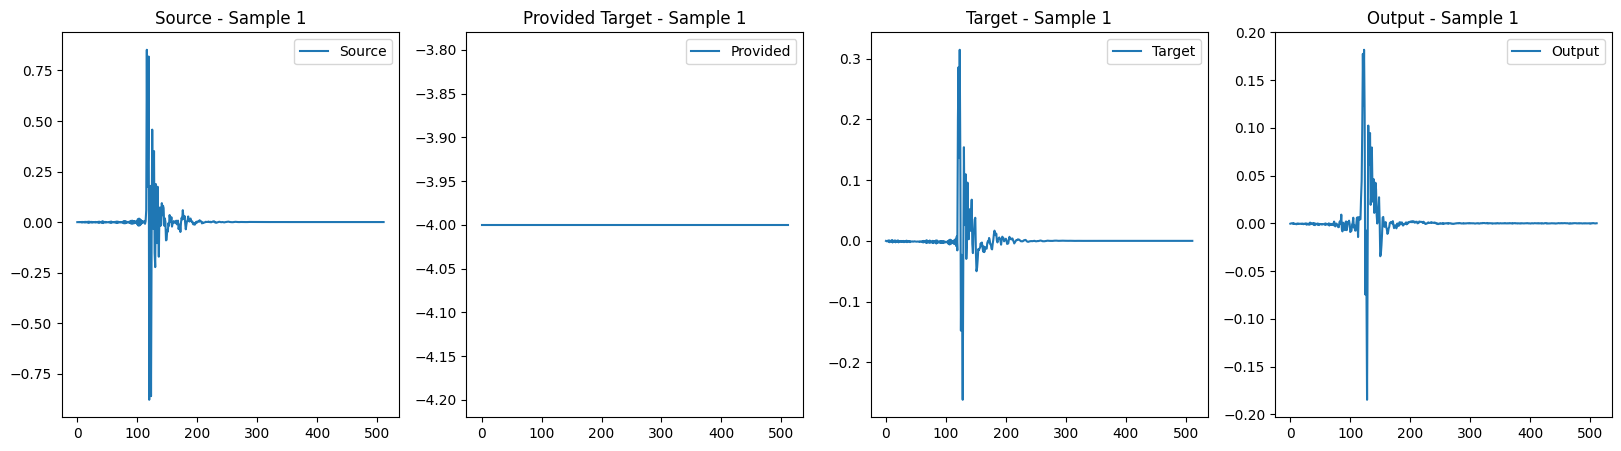

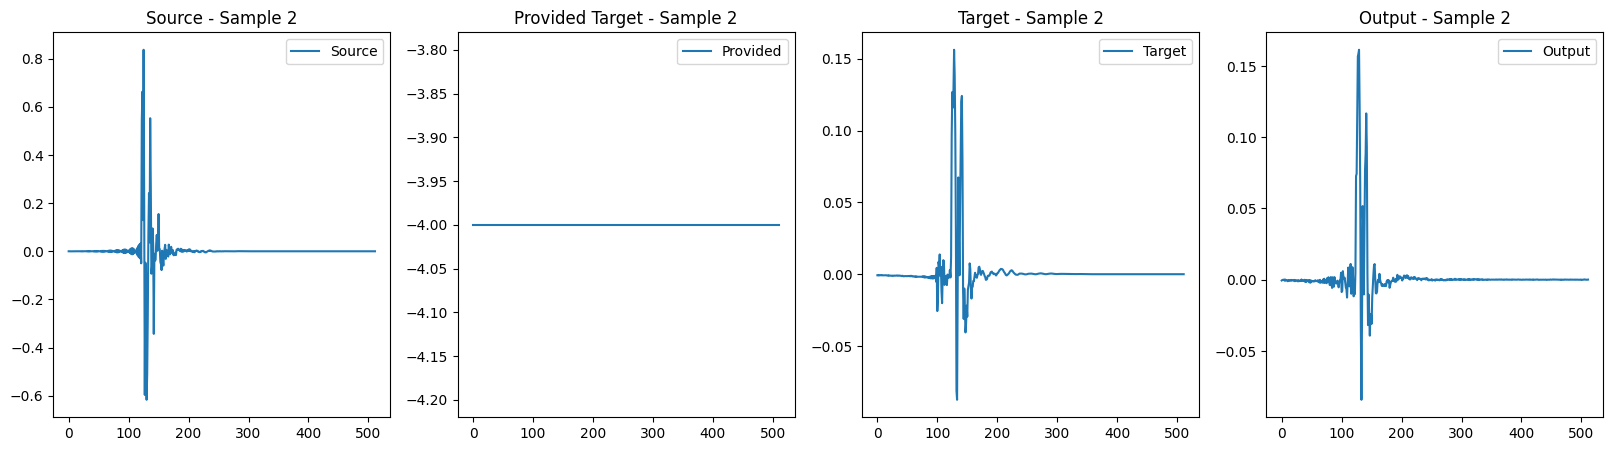

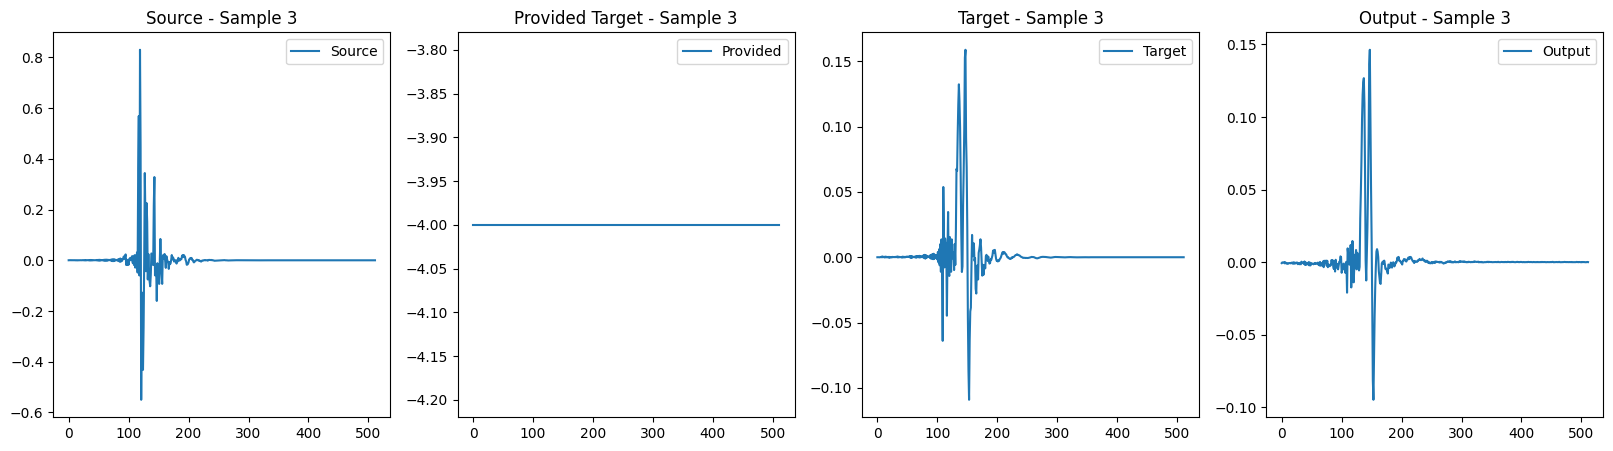

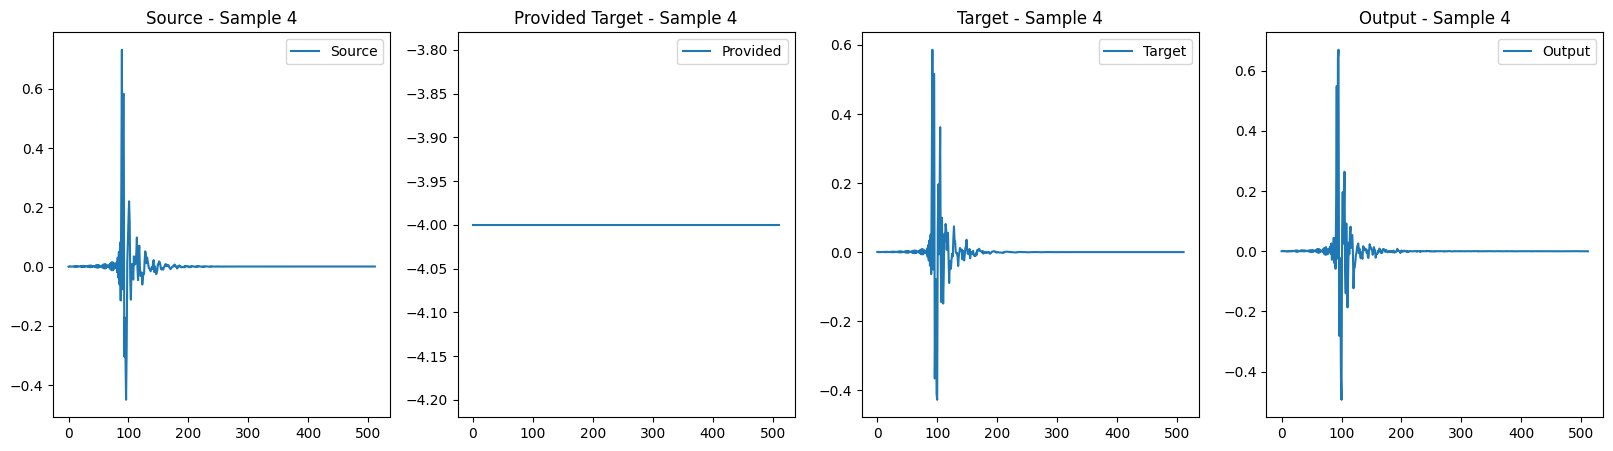

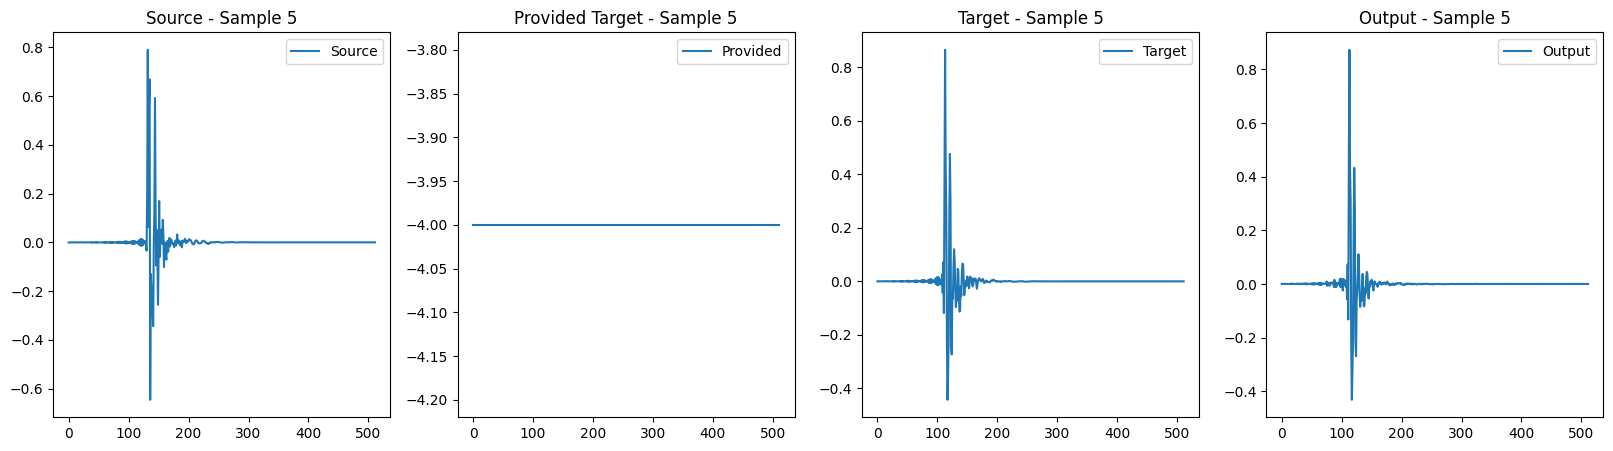

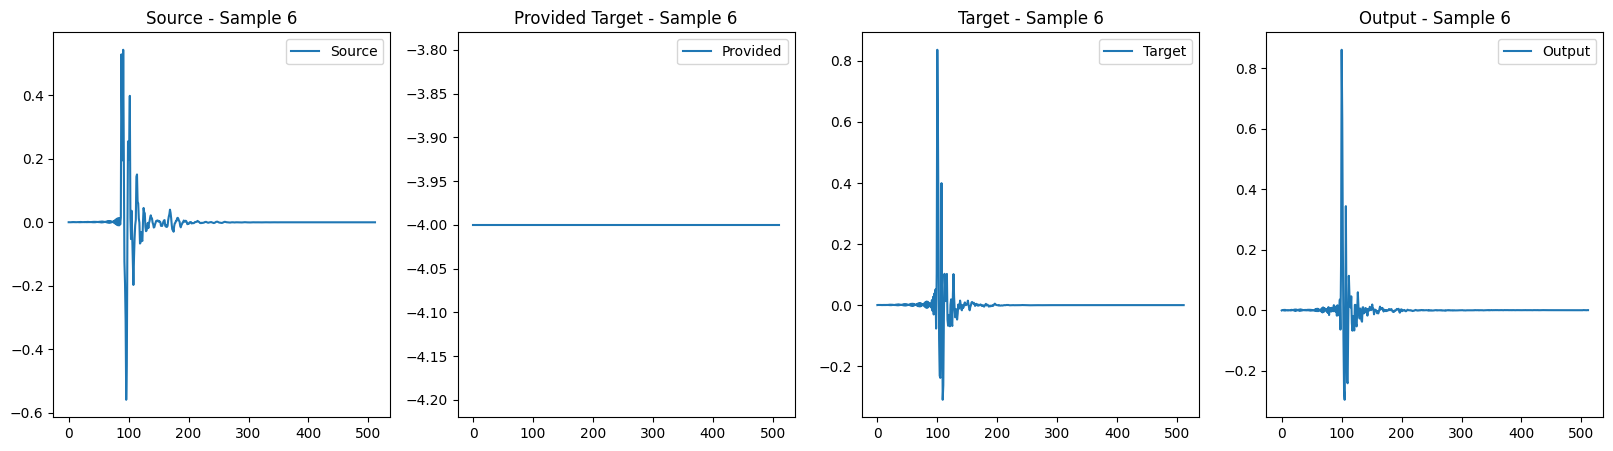

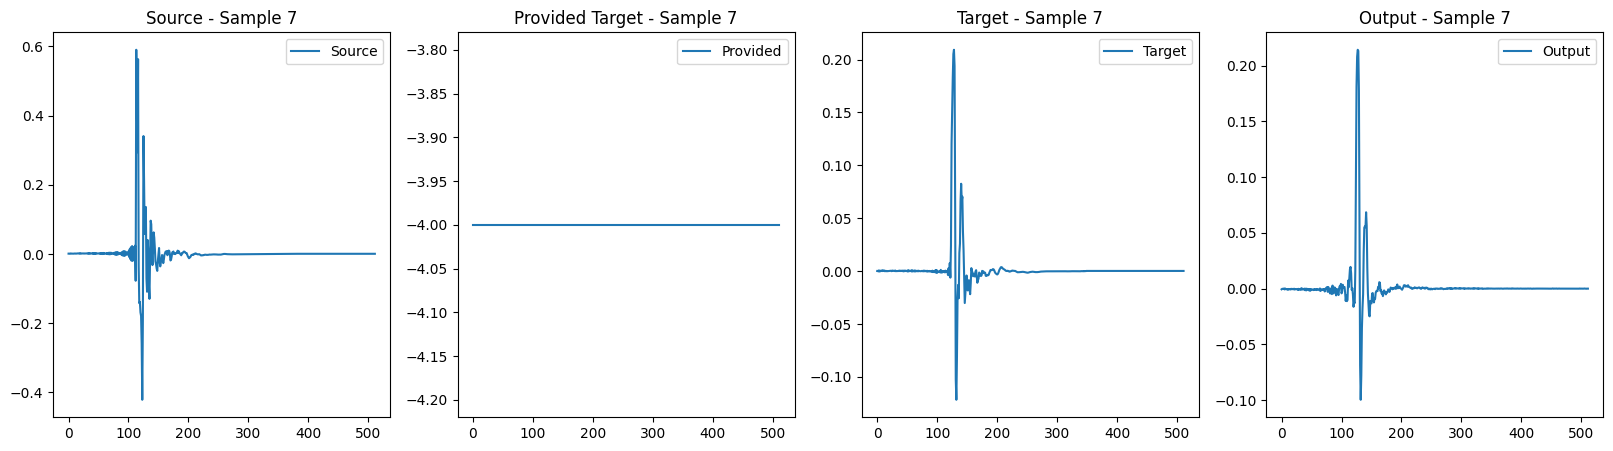

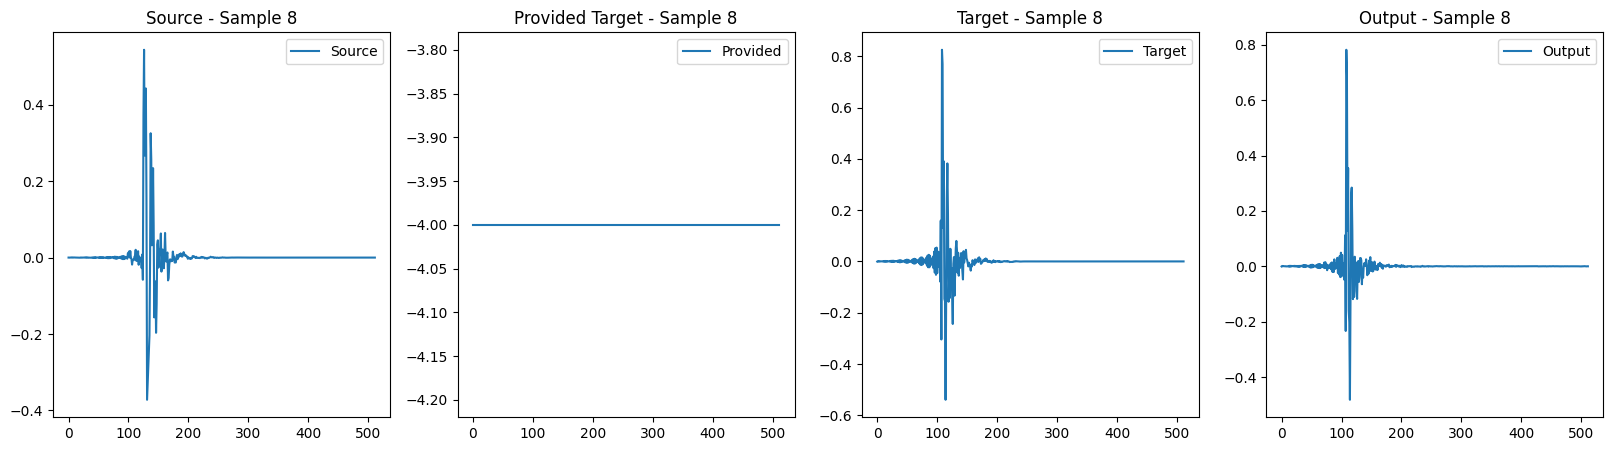

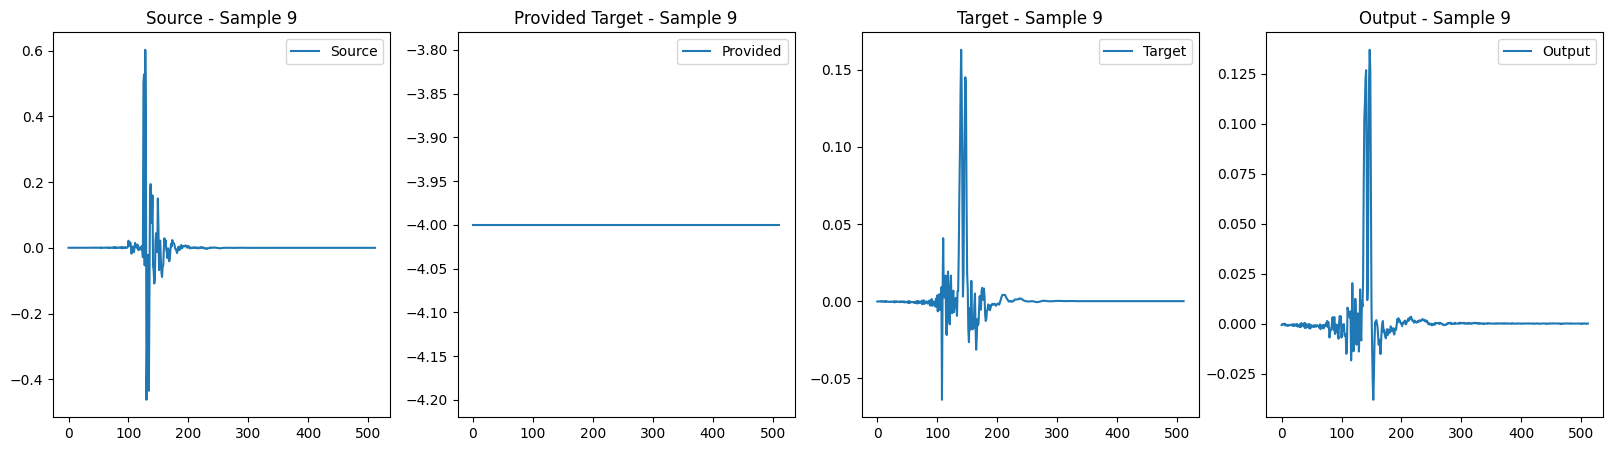

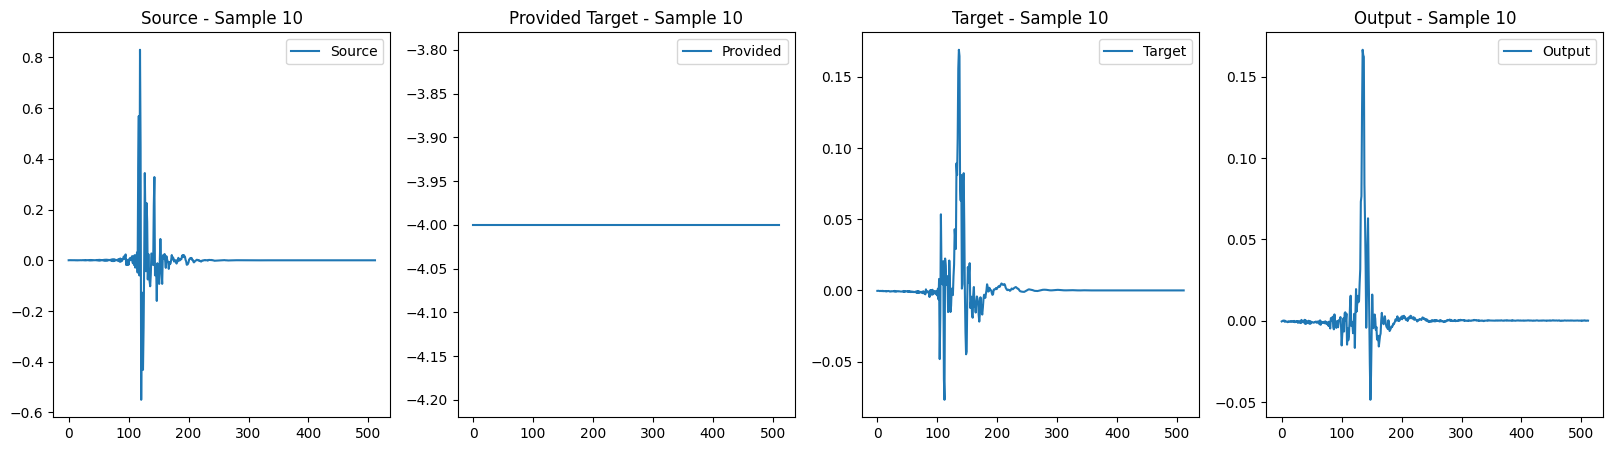

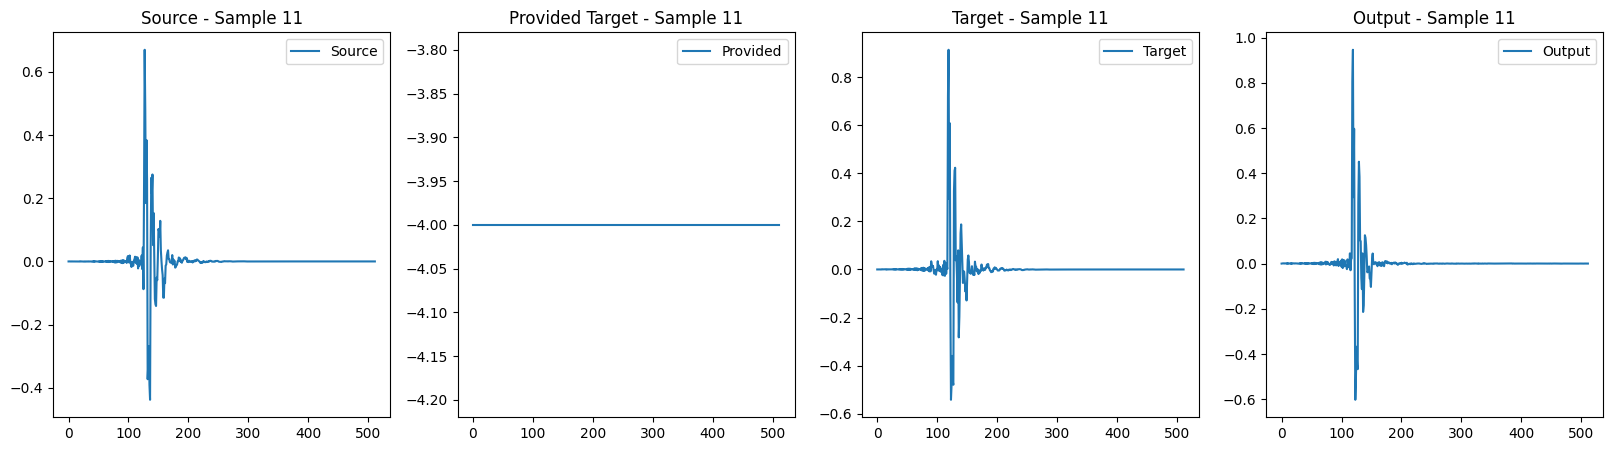

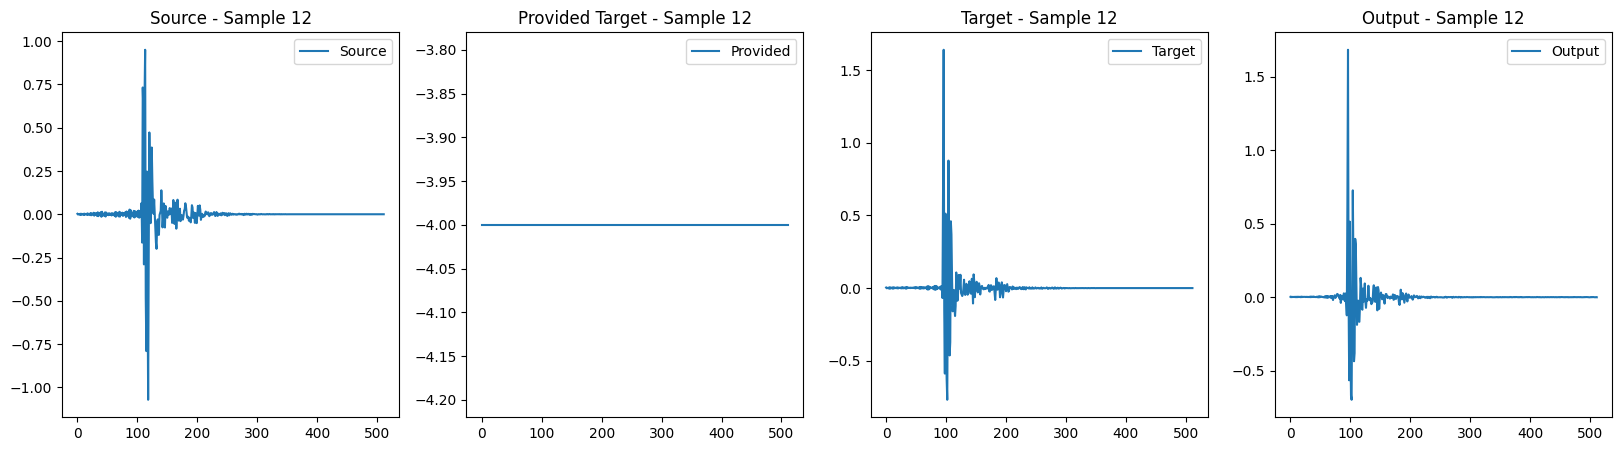

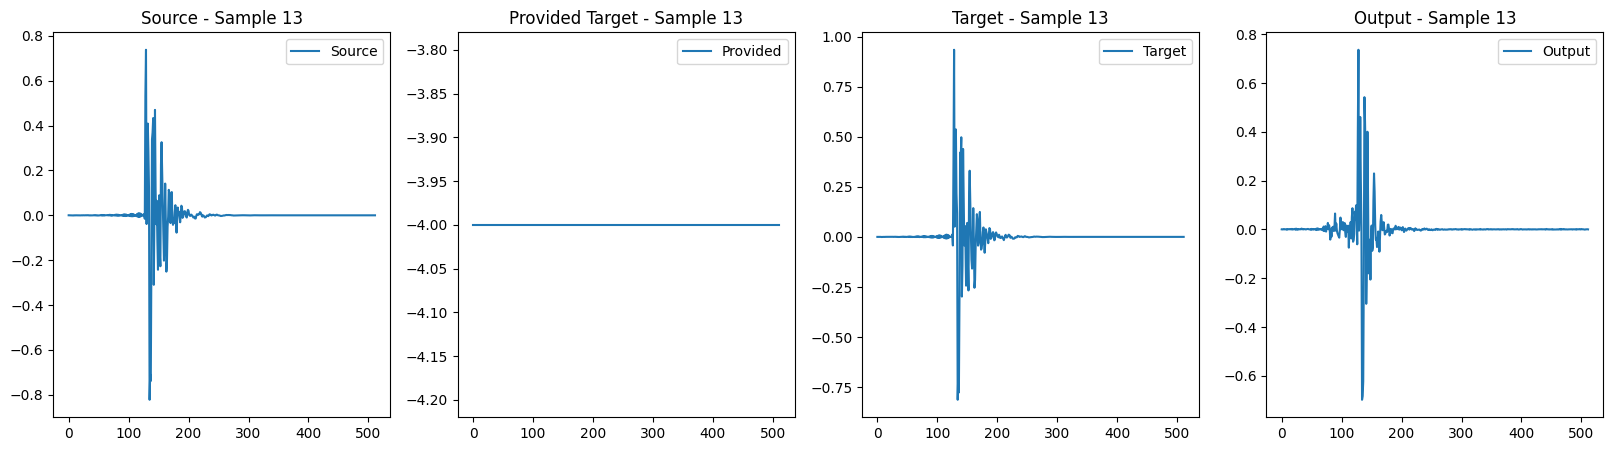

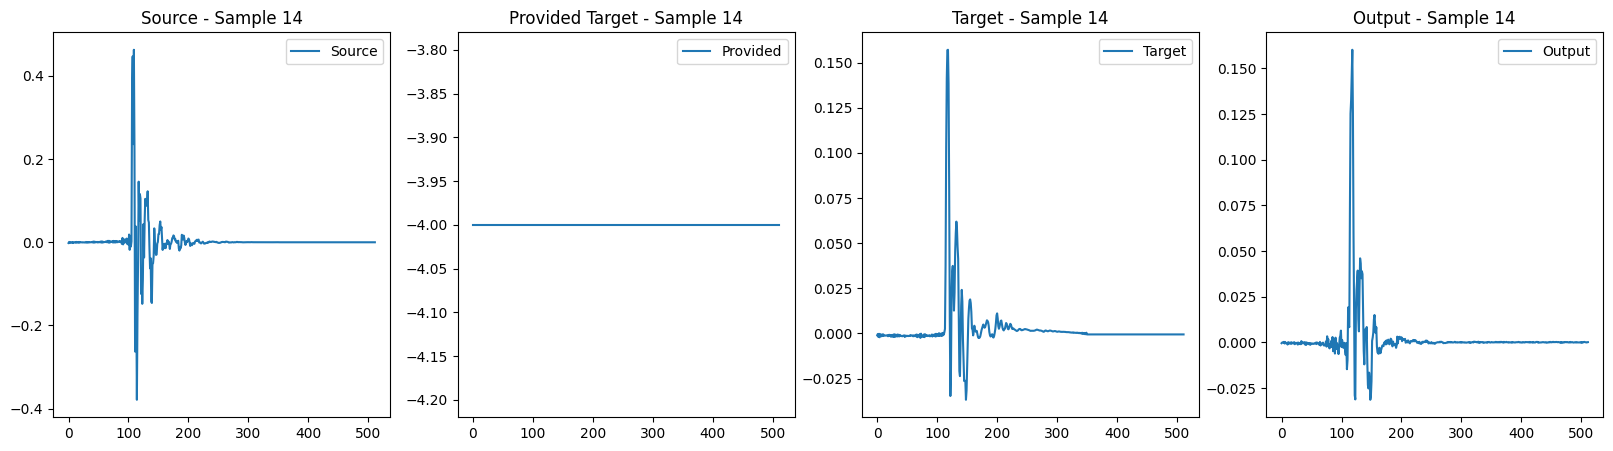

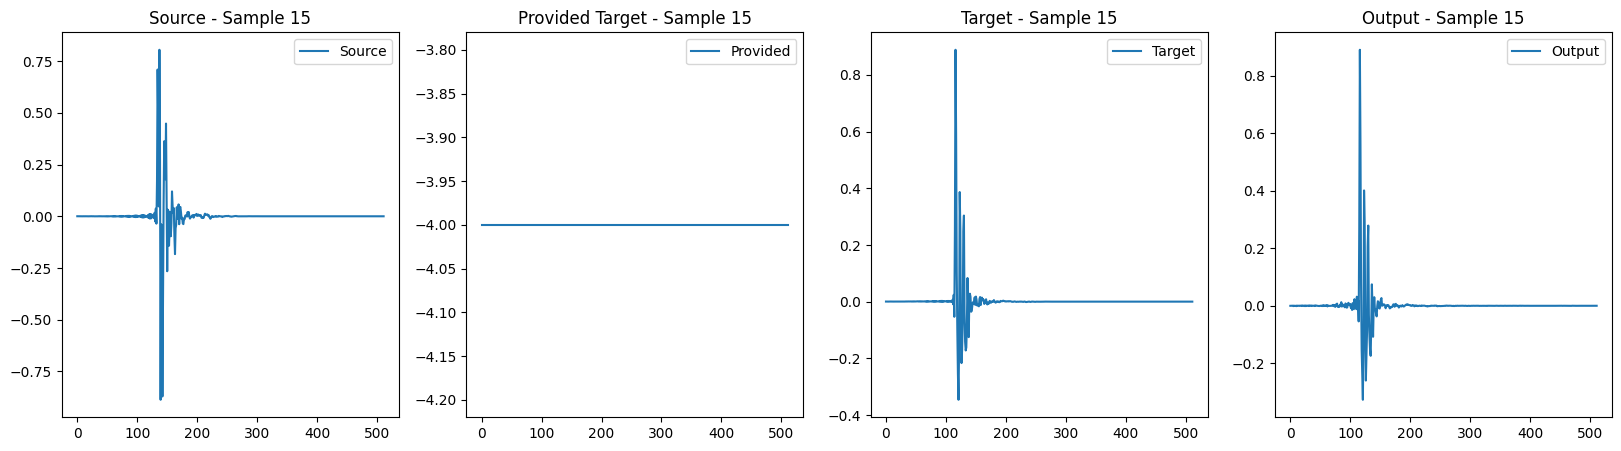

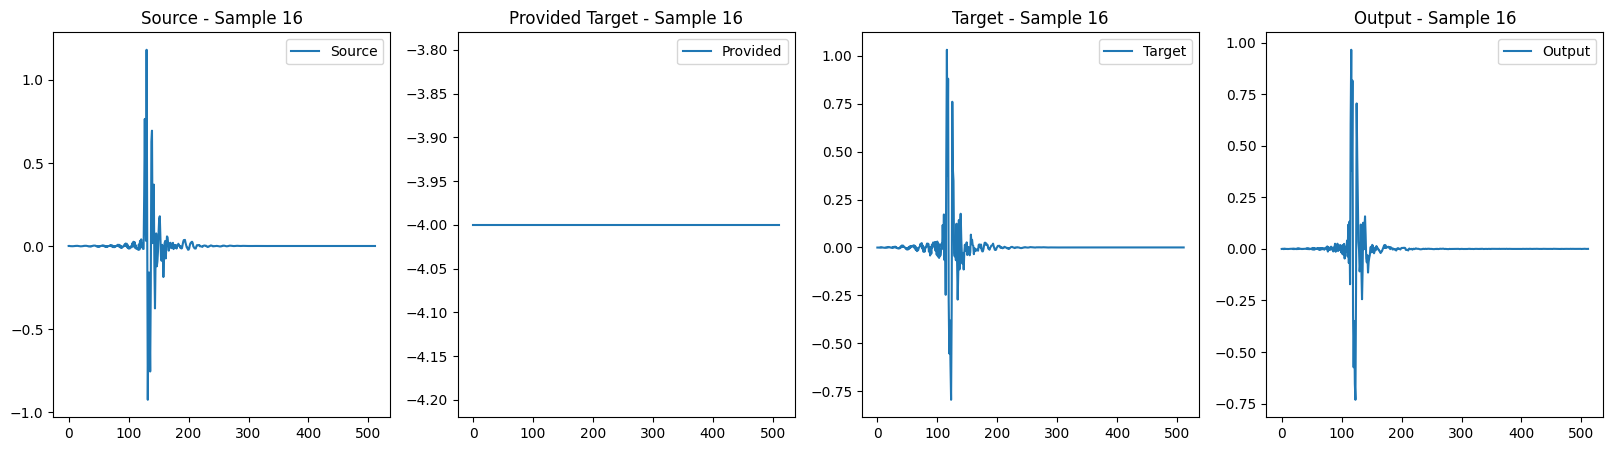

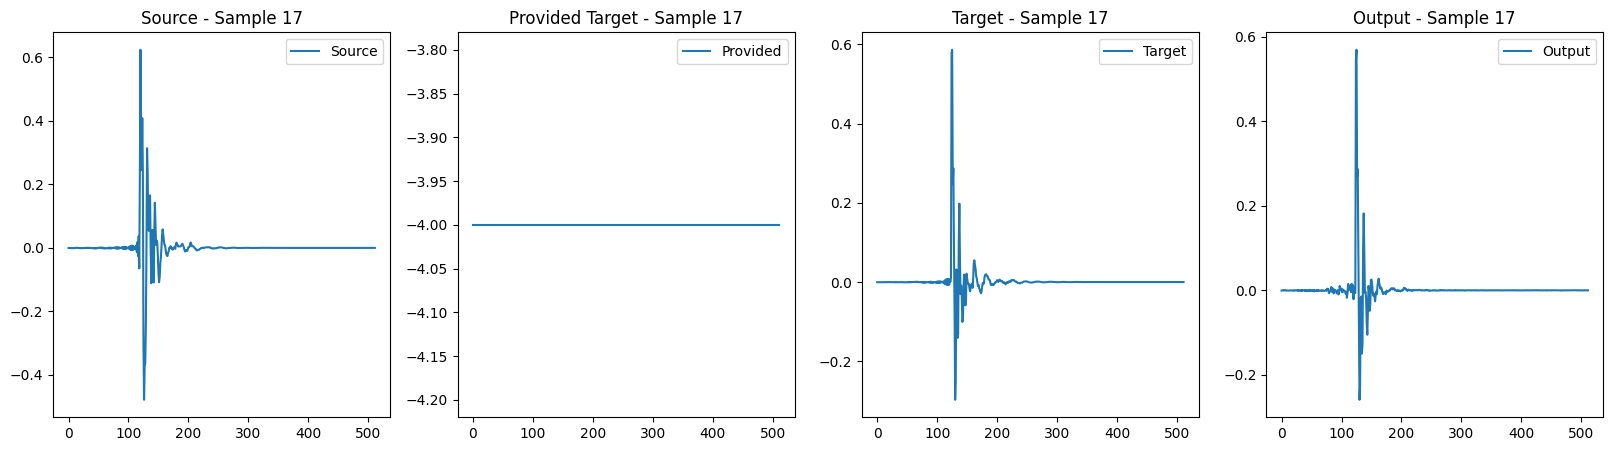

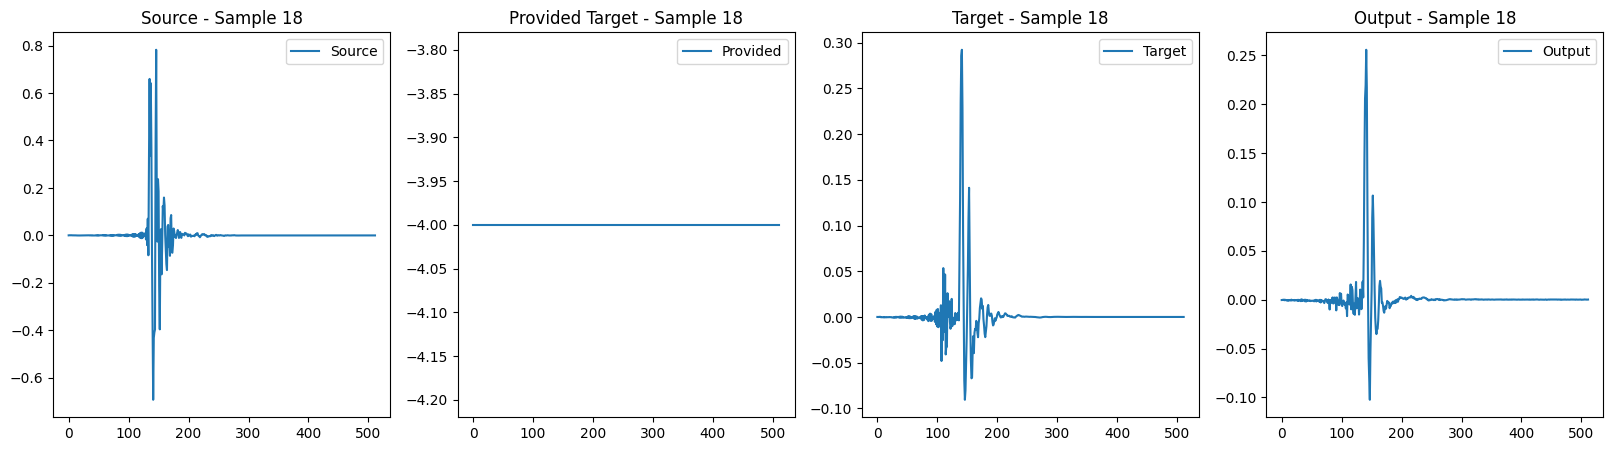

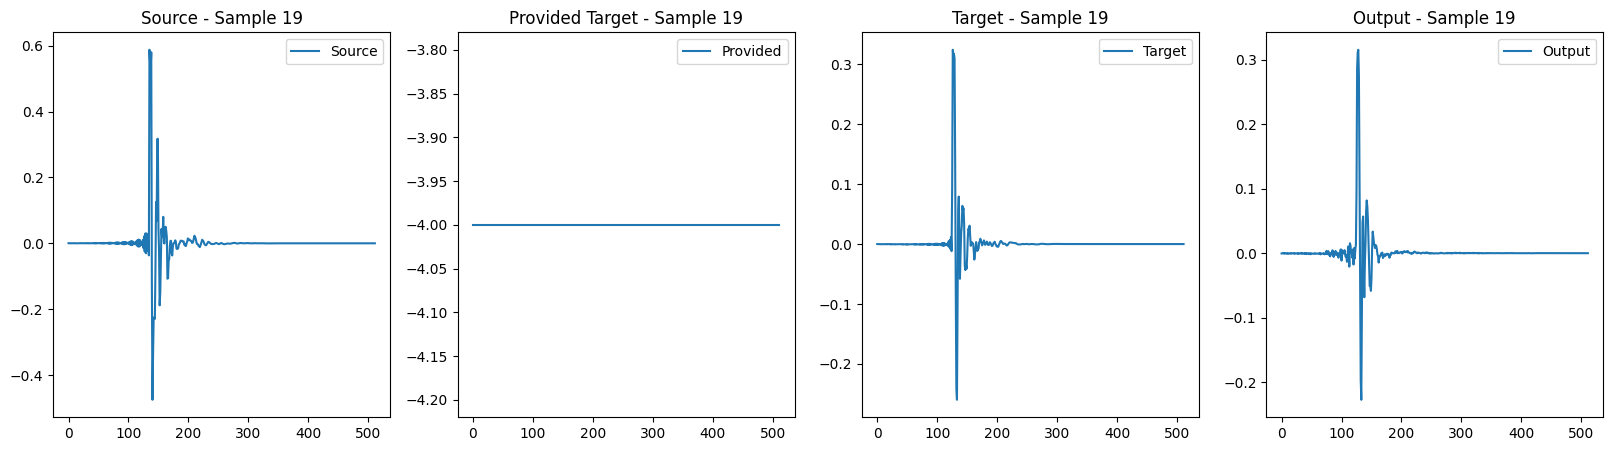

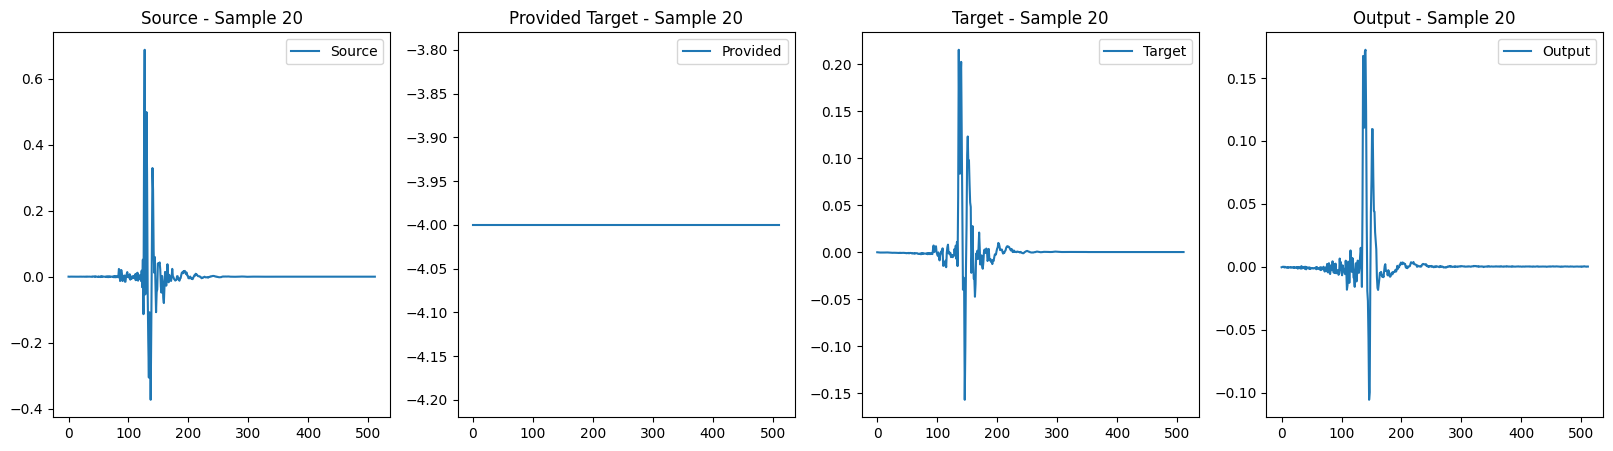

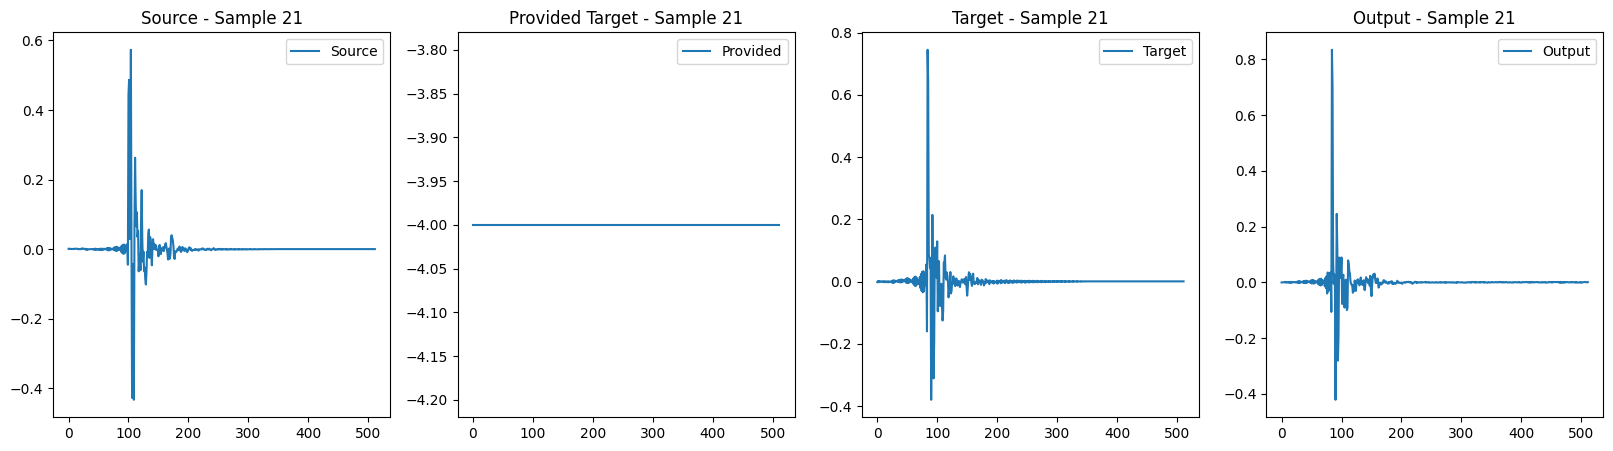

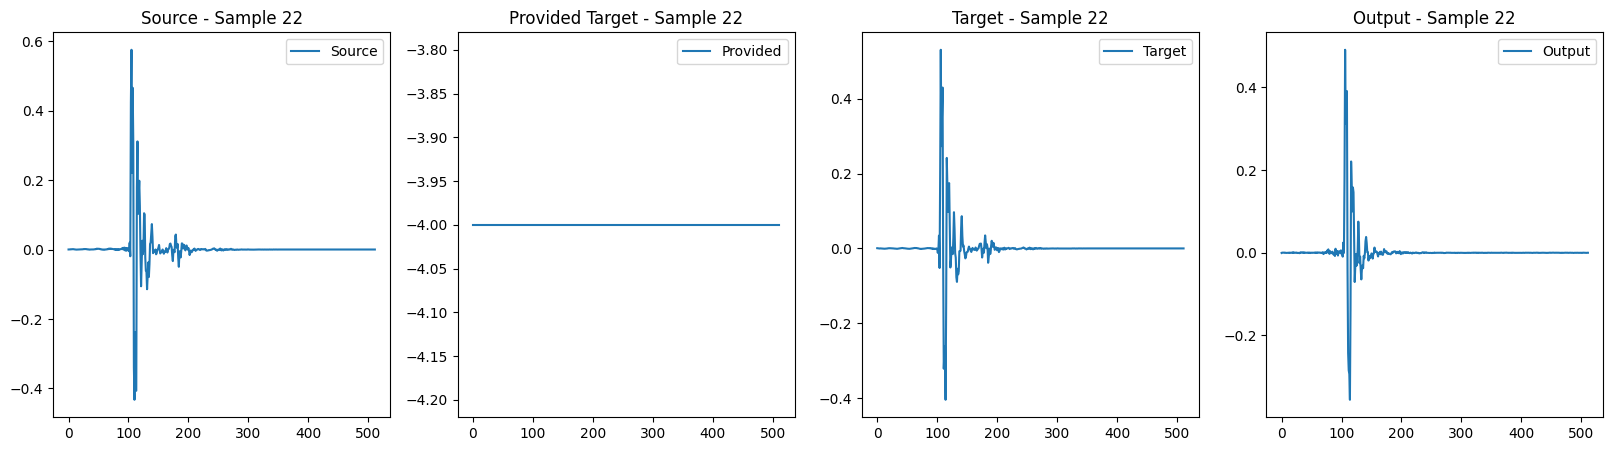

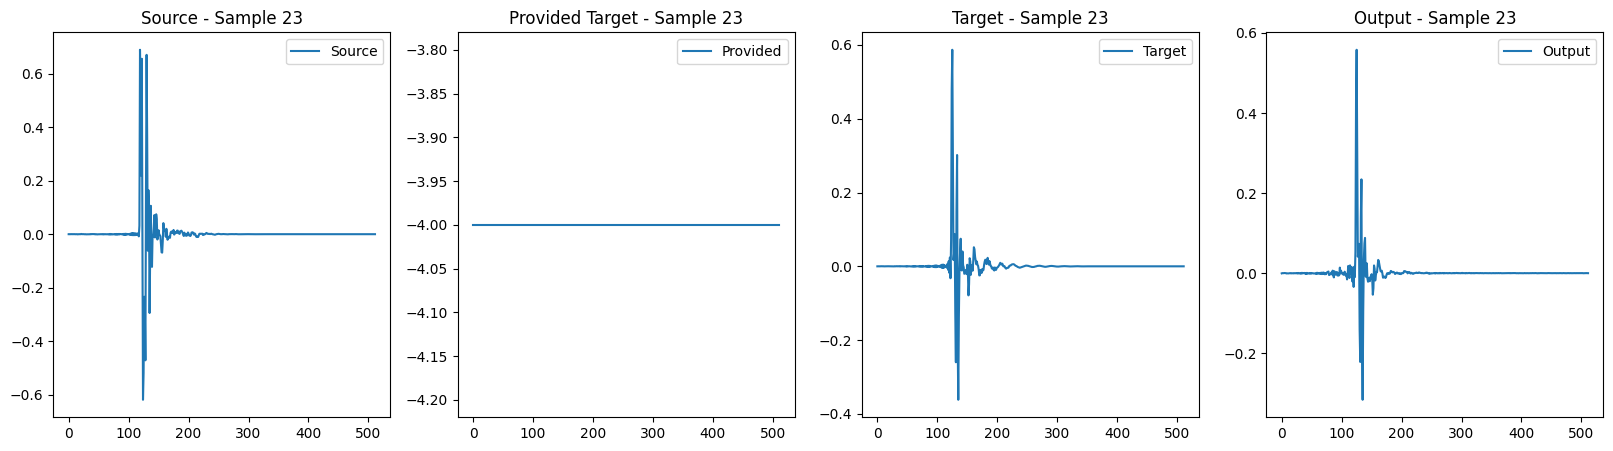

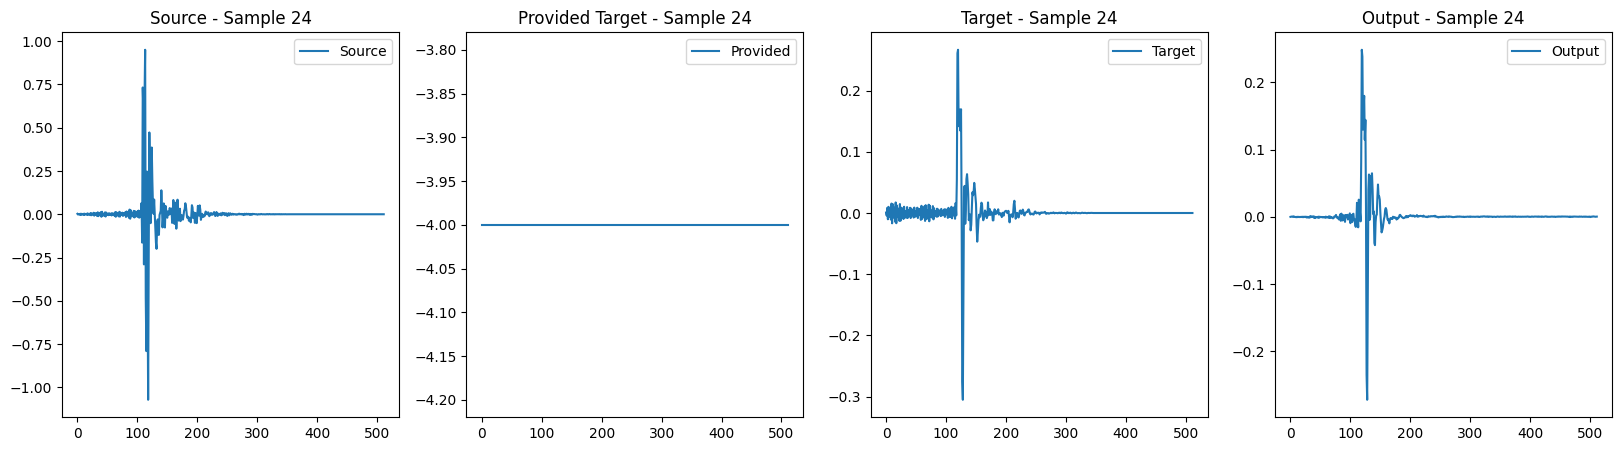

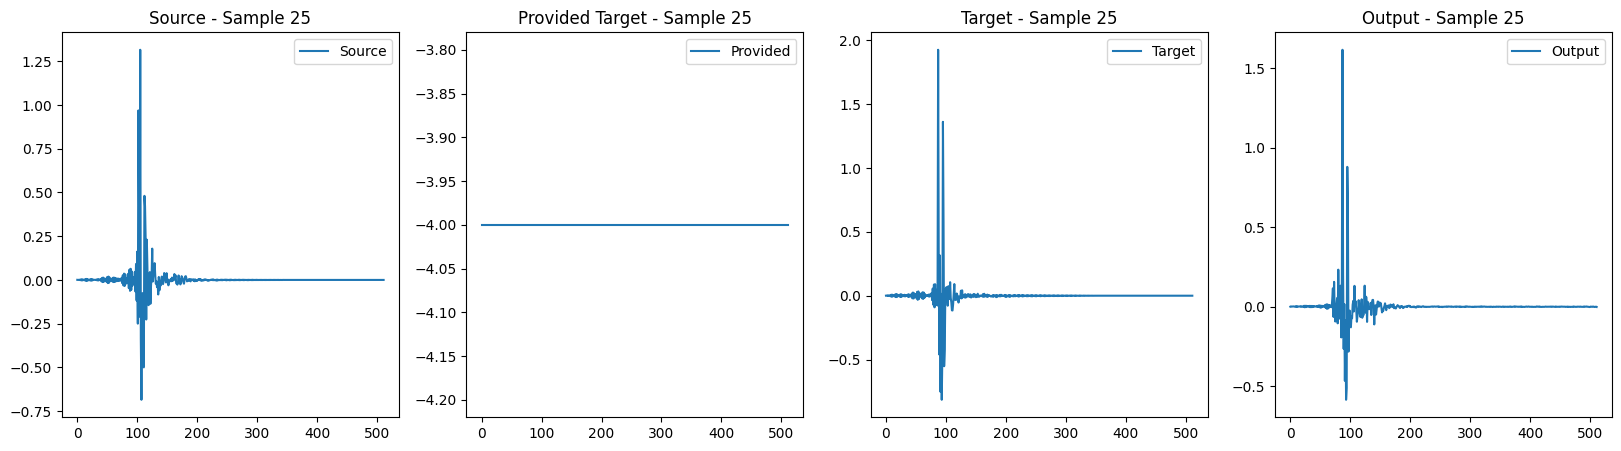

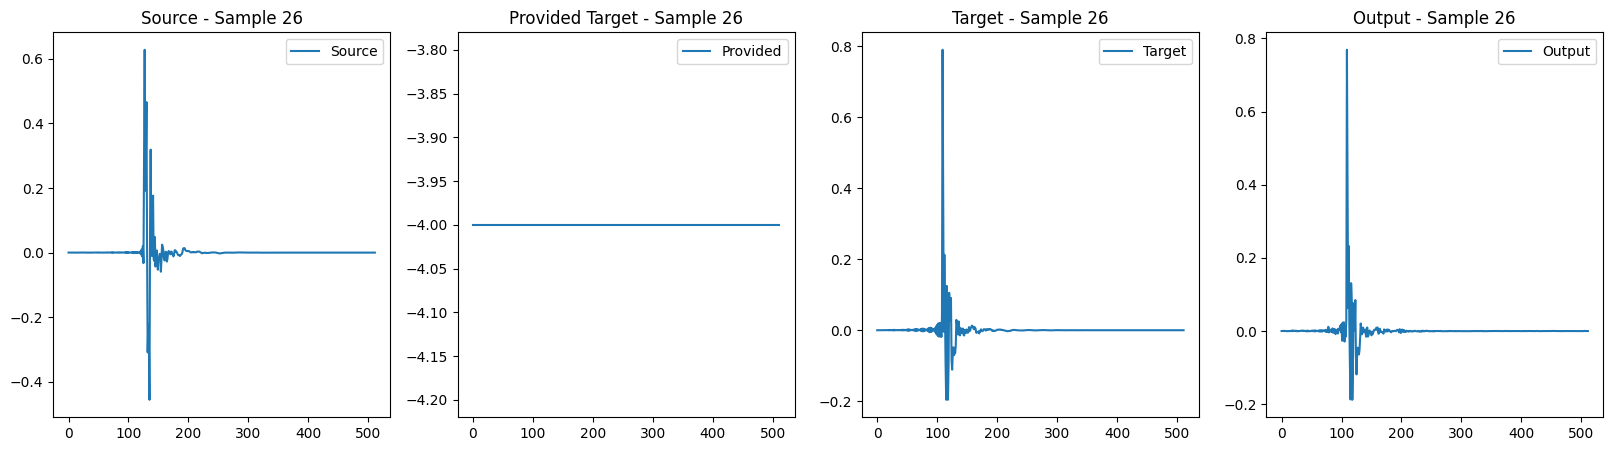

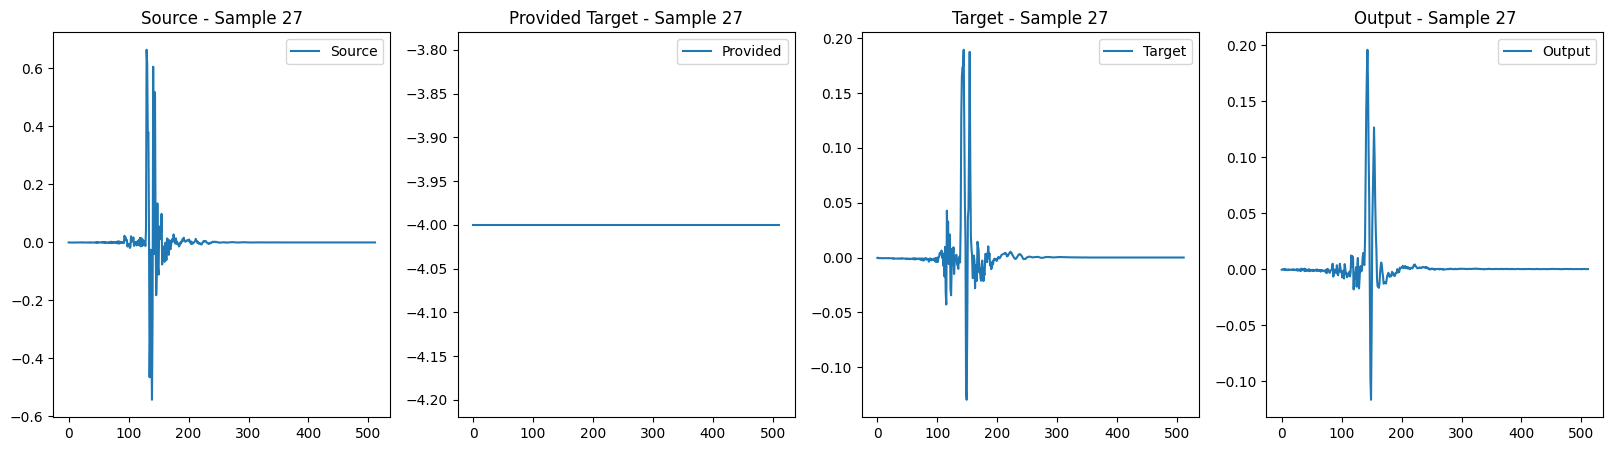

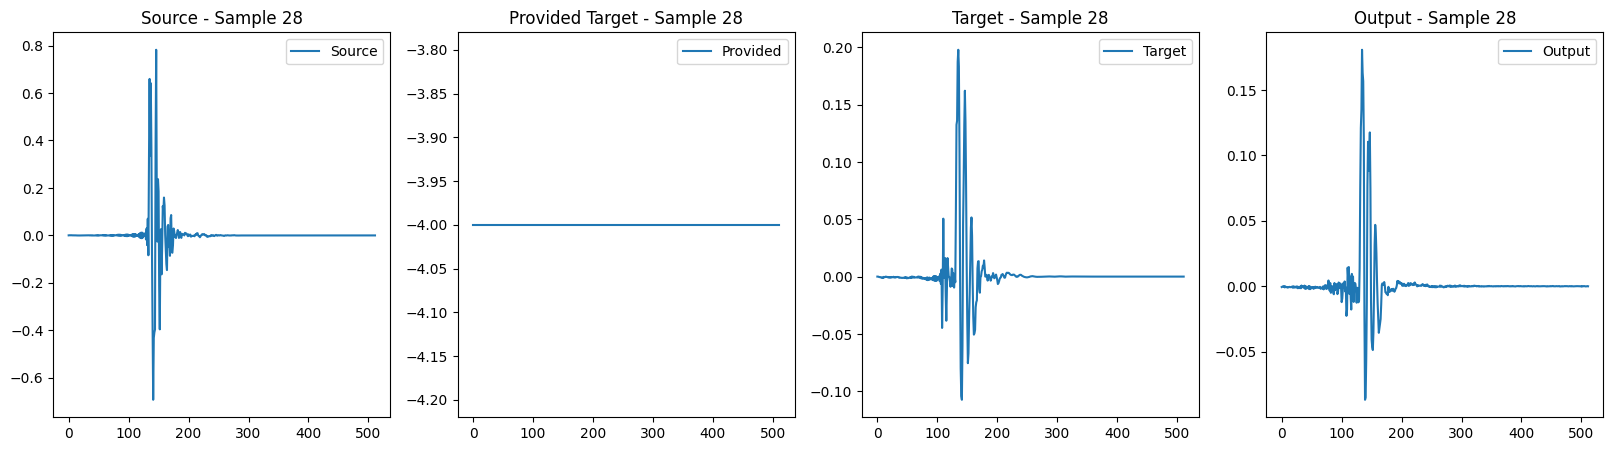

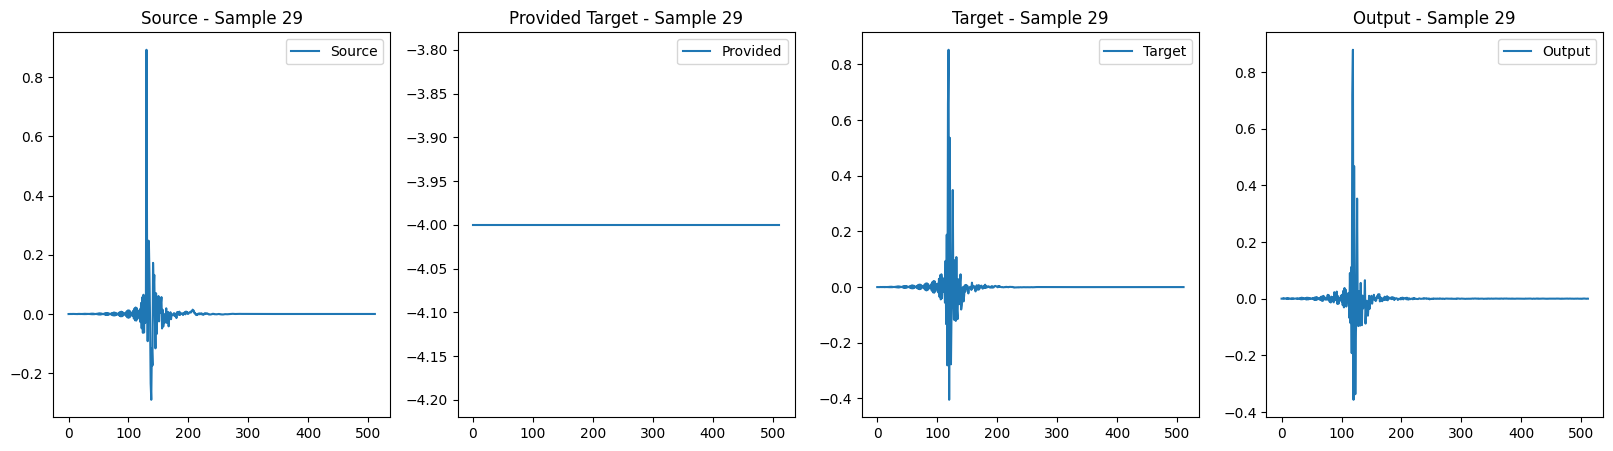

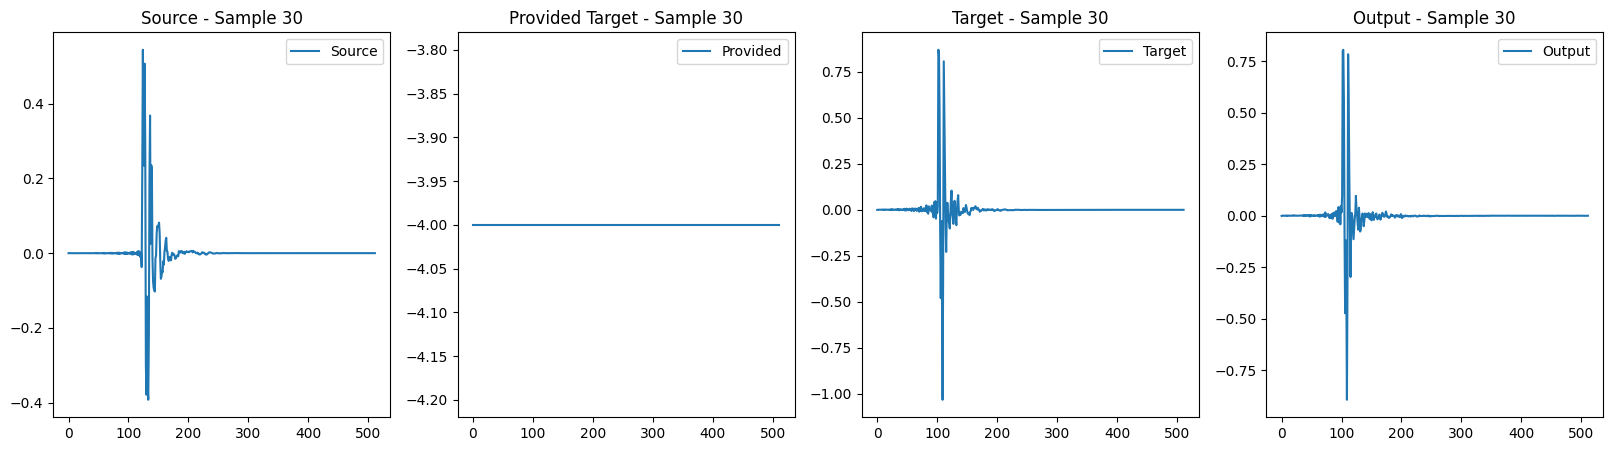

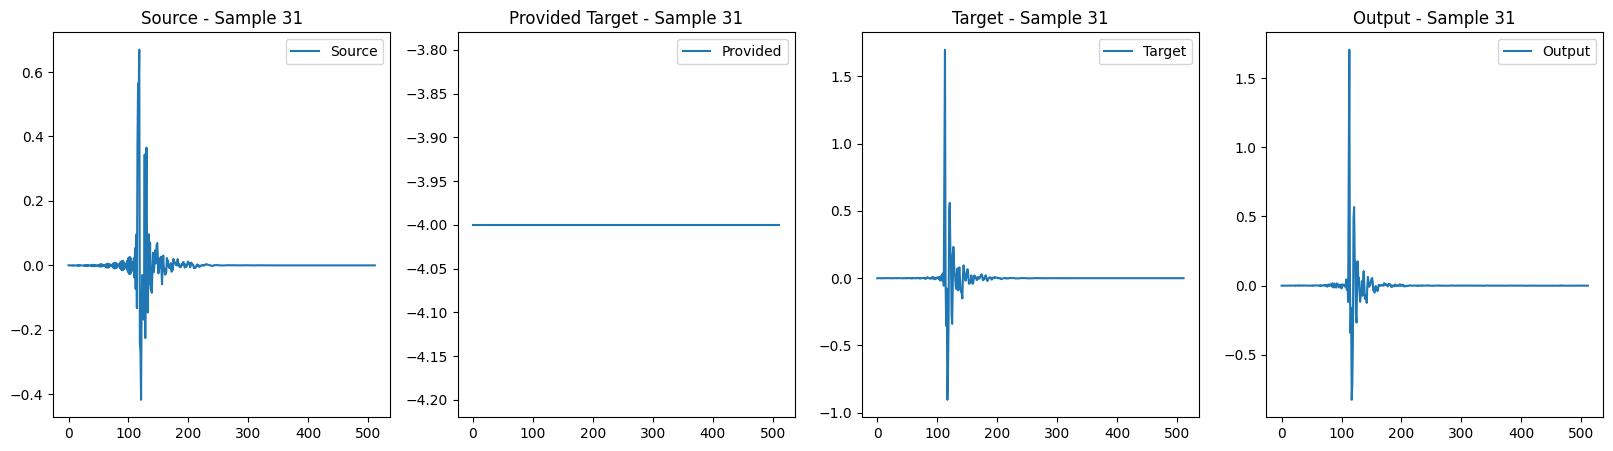

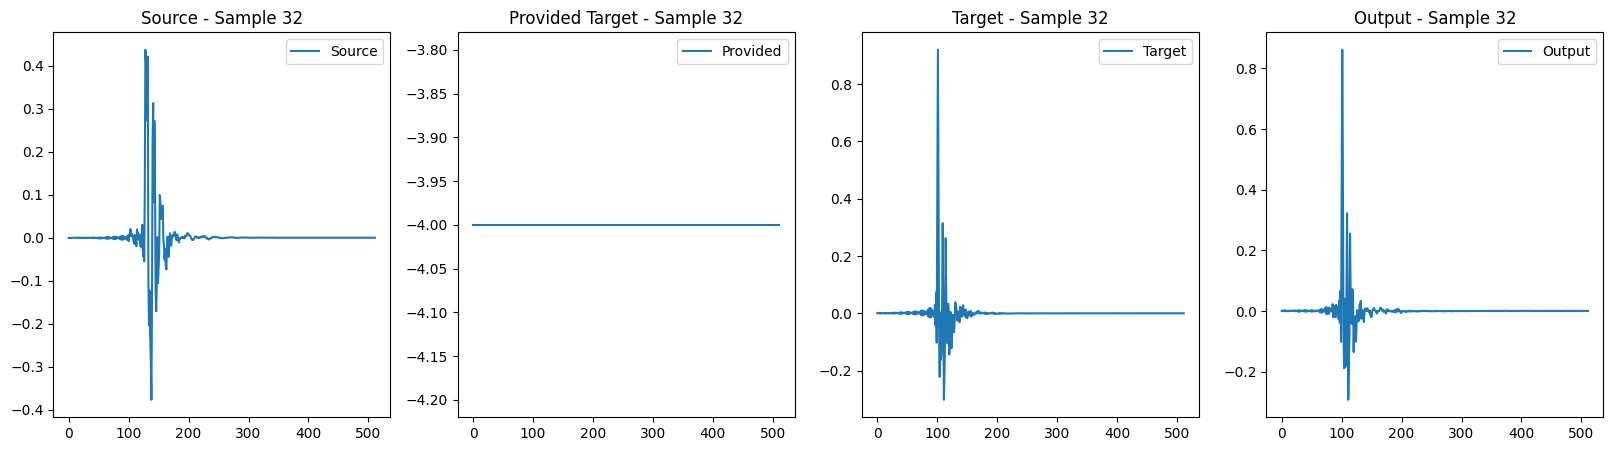

Loss: 0.0002


In [6]:
import matplotlib.pyplot as plt

def mask_portion_of_target(hrir_target, mask_pct):
    """
    Mask a portion of the targets in hrir_target with -4.
    hrir_target is expected to have shape [2, 512]
    mask_pct is the percentage of the 2*512 elements to mask in each selected target.
    """
    # Calculate the number of elements to mask in each target
    num_elements_to_mask = int(2 * 512 * mask_pct)

    # Generate random indices to mask within the 2*512 elements
    indices_to_mask = torch.randperm(2*512)[:num_elements_to_mask]

    # Apply mask to the selected indices
    hrir_target.view(-1)[indices_to_mask] = -4  # Reshape to 1D for easy indexing and mask

    return hrir_target

def test_and_plot(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # No need to track gradients
        for hrir0, angle0, hrir_target, target_angle in test_loader:
            hrir0, angle0, hrir_target, target_angle = hrir0.to(device), angle0.to(device), hrir_target.to(device), target_angle.to(device)
            hrir0 = hrir0.float()
            hrir_target = hrir_target.float()
            angle0 = angle0.long()
            target_angle = target_angle.long()

            # Assume angle_to_index is defined elsewhere
            angle0 = angle_to_index(angle0)
            target_angle = angle_to_index(target_angle)

            diffs = hrir_target - hrir0
            passed_hrir = hrir_target.clone()  # Make a copy to modify without affecting the original hrir_target

            mask_prob = 1.0
            mask_pct = 1.0
            for i in range(hrir_target.size(0)):
                if np.random.rand() < mask_prob:
                    passed_hrir[i] = mask_portion_of_target(passed_hrir[i], mask_pct)

            output = model(hrir0, angle0, passed_hrir, target_angle, diffs)
            real_target = hrir_target[:, 0, :].unsqueeze(1)
            loss = loss_function(output, real_target)

            for i in range(hrir0.size(0)):  # Iterate over each sample in the batch
                plt.figure(figsize=(20, 5))  # Adjust the figure size to better accommodate 4 plots

                plt.subplot(1, 4, 1)
                plt.plot(hrir0[i, 0].cpu().numpy(), label='Source')
                plt.title(f'Source - Sample {i+1}')
                plt.legend()

                plt.subplot(1, 4, 2)
                plt.plot(passed_hrir[i, 0].cpu().numpy(), label='Provided')
                plt.title(f'Provided Target - Sample {i+1}')
                plt.legend()

                plt.subplot(1, 4, 3)
                plt.plot(real_target[i, 0].cpu().numpy(), label='Target')
                plt.title(f'Target - Sample {i+1}')
                plt.legend()

                plt.subplot(1, 4, 4)
                plt.plot(output[i, 0].cpu().numpy(), label='Output')
                plt.title(f'Output - Sample {i+1}')
                plt.legend()

                plt.show()

            print(f'Loss: {loss.item():.4f}')
            break  # Remove this if you want to process more than the first batch

# Assuming you have a model, test_loader, and device defined
test_and_plot(model, test_loader, device)
